<a href="https://colab.research.google.com/github/ChuehanKuo/3D-Spinning-Cube-Rotational-Matrices-and-Projection/blob/main/LifeSatisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

# Try optional libs (if missing, install in your environment)
try:
    from xgboost import XGBClassifier
except Exception as e:
    XGBClassifier = None
    print("[WARN] xgboost not available:", e)

try:
    from lightgbm import LGBMClassifier
except Exception as e:
    LGBMClassifier = None
    print("[WARN] lightgbm not available:", e)

try:
    from scipy.stats import gaussian_kde
except Exception as e:
    gaussian_kde = None
    print("[WARN] scipy not available (needed for KDE plots):", e)

DATA_PATH = "/content/final_cleaned.csv"
OUTDIR = "outputs_qol_fairness"
SEED = 42

# Locked subgroup vars for rabbit-ear plots
SUBGROUP_VARS = ["country_no", "ses_q", "edu_lv", "gender", "region"]

# Validity filter for subgroup categories
MIN_N = 200
MIN_Y = 30

# Whether to exclude subgroup vars from X (recommended "unaware" setting)
UNAWAREx = True


# Utility
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

ensure_dir(OUTDIR)

In [ ]:
df = pd.read_csv(DATA_PATH)

required = ["satisfied_life", "eurod_categ", "casp_12", "hh_income",
            "country_no", "edu_lv", "gender", "region"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing required columns: {missing}")

print("df shape:", df.shape)
print(df[["satisfied_life", "eurod_categ", "casp_12"]].describe())
print("\nEURO-D counts:\n", df["eurod_categ"].value_counts(dropna=False))

df shape: (51720, 175)
       satisfied_life   eurod_categ       casp_12
count    51720.000000  51720.000000  51720.000000
mean         7.965081      0.263167     37.731690
std          1.599264      0.440357      6.043258
min          0.000000      0.000000     12.000000
25%          7.000000      0.000000     34.000000
50%          8.000000      0.000000     38.000000
75%          9.000000      1.000000     42.000000
max         10.000000      1.000000     48.000000

EURO-D counts:
 eurod_categ
0    38109
1    13611
Name: count, dtype: int64


In [ ]:
df["y_eurod"] = (df["eurod_categ"] == 1).astype(int)
df["y_ls"]    = (df["satisfied_life"] <= 7).astype(int)
df["y_casp"]  = (df["casp_12"] <= 34).astype(int)

print("\nPrevalence (mean of y):")
for ycol in ["y_eurod", "y_ls", "y_casp"]:
    print(ycol, df[ycol].mean())



Prevalence (mean of y):
y_eurod 0.26316705336426915
y_ls 0.2993426140757927
y_casp 0.2908739365815932


In [ ]:
df["ses_q"] = pd.qcut(df["hh_income"], 5, labels=[1,2,3,4,5], duplicates="drop").astype(int)

if "age" in df.columns:
    df["age_band"] = pd.cut(
        df["age"],
        bins=[49, 59, 69, 79, 150],
        labels=["50-59", "60-69", "70-79", "80+"],
        right=True
    )
    print("\nAge band distribution:\n", df["age_band"].value_counts(dropna=False, normalize=True).mul(100).round(2))
else:
    df["age_band"] = np.nan
    print("\n[INFO] 'age' not found; age_band will be NaN")

print("\nSES quintiles distribution:\n", df["ses_q"].value_counts().sort_index())


Age band distribution:
 age_band
60-69    35.66
70-79    32.30
50-59    16.25
80+      15.79
Name: proportion, dtype: float64

SES quintiles distribution:
 ses_q
1    10344
2    10381
3    10307
4    10843
5     9845
Name: count, dtype: int64


In [ ]:
def valid_categories(df_in: pd.DataFrame, group_col: str, y_col: str):
    """Return categories meeting min total and min per-class counts."""
    g = df_in.groupby(group_col)[y_col].agg(
        n="count",
        y1="sum"
    )
    g["y0"] = g["n"] - g["y1"]
    ok = g[(g["n"] >= MIN_N) & (g["y1"] >= MIN_Y) & (g["y0"] >= MIN_Y)].index.tolist()
    return ok, g.reset_index()

# quick check
for gcol in SUBGROUP_VARS:
    ok, summary = valid_categories(df, gcol, "y_eurod")
    print(f"\nValid categories for {gcol} (using y_eurod as example): {len(ok)} / {summary.shape[0]}")



Valid categories for country_no (using y_eurod as example): 5 / 5

Valid categories for ses_q (using y_eurod as example): 5 / 5

Valid categories for edu_lv (using y_eurod as example): 3 / 3

Valid categories for gender (using y_eurod as example): 2 / 2

Valid categories for region (using y_eurod as example): 2 / 2


In [ ]:
EUROD_ITEMS = [
    "appetite","concentration","depression","enjoyment","fatigue","guilt",
    "interest","irritability","pessimism","sleep","suicidality","tearfulness"
]

In [ ]:
ID_COLS = ["mergeid"] if "mergeid" in df.columns else []
RAW_OUTCOME_COLS = ["satisfied_life","eurod_categ","casp_12"]
Y_COLS = ["y_eurod","y_ls","y_casp"]

# Block 1 — demographics
block1 = ["age_band", "gender", "marital", "children", "grandchildren", "residence_type"]
block1 = [c for c in block1 if c in df.columns]

# Block 2 add — socioeconomic
block2_add = [
    "edu_lv", "hh_income",
    "income_work", "income_self_work", "income_house",
    "value_house", "value_car", "value_business",
    "bank_account", "bond_stock_funds",
    "oldage_pension", "occupational_pension", "private_pensions",
    "unemployment_benefits", "sickness_benefit", "disability_pension",
    "supplementary_insurance"
]
block2_add = [c for c in block2_add if c in df.columns]

# Forbidden columns for any X
FORBIDDEN_BASE = set(ID_COLS + RAW_OUTCOME_COLS + Y_COLS)

# Health add — heuristic:
# "everything else" after removing forbidden + blocks + subgroup vars (if UNAWAREx)
base_exclude = set(block1 + block2_add) | FORBIDDEN_BASE
if UNAWAREx:
    base_exclude |= set(SUBGROUP_VARS)

# Additionally exclude obvious leakage-ish columns you might want to avoid across outcomes
# (keep minimal; you can extend)
# base_exclude |= set(["country_ses"])  # if you create it later

health_add = [c for c in df.columns if c not in base_exclude]

BLOCKS = {
    "B1": block1,
    "B2": block1 + block2_add,
    "B3": block1 + block2_add + health_add
}

print("\nBlock sizes:")
for bname, cols in BLOCKS.items():
    print(bname, len(cols))


Block sizes:
B1 6
B2 23
B3 170


In [ ]:
def build_preprocess(X: pd.DataFrame):
    # Treat object/category/bool as categorical; everything numeric as numeric
    cat_cols = [c for c in X.columns if (X[c].dtype == "object" or str(X[c].dtype).startswith("category") or X[c].dtype == "bool")]
    num_cols = [c for c in X.columns if c not in cat_cols]

    numeric_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ])

    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, num_cols),
            ("cat", categorical_pipe, cat_cols)
        ],
        remainder="drop"
    )
    return preprocess, num_cols, cat_cols

In [ ]:
def make_models(scale_pos_weight: float):
    models = {}

    models["logreg"] = LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        n_jobs=-1
    )

    models["rf"] = RandomForestClassifier(
        n_estimators=500,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample"
    )

    if XGBClassifier is not None:
        models["xgb"] = XGBClassifier(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=SEED,
            n_jobs=-1,
            eval_metric="logloss",
            scale_pos_weight=scale_pos_weight
        )

    if LGBMClassifier is not None:
        models["lgbm"] = LGBMClassifier(
            n_estimators=1200,
            learning_rate=0.03,
            num_leaves=31,
            min_data_in_leaf=50,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=SEED,
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight
        )

    return models

def safe_auc(y_true, p):
    # If y_true has single class, AUC undefined
    if len(np.unique(y_true)) < 2:
        return np.nan, np.nan
    return roc_auc_score(y_true, p), average_precision_score(y_true, p)

def stratified_60_20_20_split(X, y):
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, y, test_size=0.4, random_state=SEED, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.5, random_state=SEED, stratify=y_tmp
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
OUTCOMES = {
    "eurod": "y_eurod",
    "life_satisfaction": "y_ls",
    "casp12": "y_casp"
}

all_best = []

for outcome_name, ycol in OUTCOMES.items():
    for block_name, block_cols in BLOCKS.items():

        run_dir = os.path.join(OUTDIR, outcome_name, block_name)
        ensure_dir(run_dir)

        # Build X columns from block, then remove forbidden columns if they accidentally appear
        X_cols = [c for c in block_cols if c in df.columns]

        # Outcome-specific leakage prevention (EURO-D model)
        if ycol == "y_eurod":
            X_cols = [c for c in X_cols if c not in EUROD_ITEMS]

        # Unaware setting: exclude subgroup vars if they show up in blocks
        if UNAWAREx:
            X_cols = [c for c in X_cols if c not in SUBGROUP_VARS]

        # Always exclude raw outcomes/labels/IDs if accidentally included
        X_cols = [c for c in X_cols if c not in FORBIDDEN_BASE]

        # Build dataframes
        X = df[X_cols].copy()
        y = df[ycol].copy().astype(int)

        # Split
        X_train, X_val, X_test, y_train, y_val, y_test = stratified_60_20_20_split(X, y)

        # scale_pos_weight
        n_pos = int(y_train.sum())
        n_neg = int((y_train == 0).sum())
        spw = (n_neg / max(n_pos, 1))

        preprocess, num_cols, cat_cols = build_preprocess(X_train)

        models = make_models(scale_pos_weight=spw)

        rows = []
        best_key = None
        best_val_pr = -np.inf
        best_val_roc = -np.inf
        best_pipe = None
        best_p_test = None

        for mname, model in models.items():
            pipe = Pipeline(steps=[
                ("prep", preprocess),
                ("model", model)
            ])

            pipe.fit(X_train, y_train)

            p_val = pipe.predict_proba(X_val)[:, 1]
            p_test = pipe.predict_proba(X_test)[:, 1]

            val_roc, val_pr = safe_auc(y_val, p_val)
            test_roc, test_pr = safe_auc(y_test, p_test)

            rows.append({
                "outcome": outcome_name,
                "ycol": ycol,
                "block": block_name,
                "model": mname,
                "val_roc_auc": val_roc,
                "val_pr_auc": val_pr,
                "test_roc_auc": test_roc,
                "test_pr_auc": test_pr,
                "n_train": len(y_train),
                "n_val": len(y_val),
                "n_test": len(y_test),
                "pos_train": int(y_train.sum()),
                "pos_val": int(y_val.sum()),
                "pos_test": int(y_test.sum()),
                "num_features": len(X_cols),
                "num_numeric": len(num_cols),
                "num_categorical": len(cat_cols)
            })

            # Selection: best by val PR-AUC, tie-break ROC-AUC
            if (val_pr > best_val_pr) or (np.isclose(val_pr, best_val_pr) and val_roc > best_val_roc):
                best_val_pr = val_pr
                best_val_roc = val_roc
                best_key = mname
                best_pipe = pipe
                best_p_test = p_test

        sweep_df = pd.DataFrame(rows).sort_values(["val_pr_auc", "val_roc_auc"], ascending=False)
        sweep_path = os.path.join(run_dir, "model_sweep.csv")
        sweep_df.to_csv(sweep_path, index=False)

        best_row = sweep_df.iloc[0].to_dict()
        best_info = {
            "outcome": outcome_name,
            "ycol": ycol,
            "block": block_name,
            "best_model": best_key,
            "selection_rule": "max val PR-AUC, tie-break val ROC-AUC",
            "best_val_pr_auc": float(best_row["val_pr_auc"]),
            "best_val_roc_auc": float(best_row["val_roc_auc"]),
            "best_test_pr_auc": float(best_row["test_pr_auc"]),
            "best_test_roc_auc": float(best_row["test_roc_auc"]),
            "UNAWAREx": bool(UNAWAREx),
            "MIN_N": MIN_N,
            "MIN_Y": MIN_Y,
            "X_num_features": int(best_row["num_features"])
        }
        with open(os.path.join(run_dir, "best_model.json"), "w") as f:
            json.dump(best_info, f, indent=2)

        # Save test predictions with subgroup vars
        pred_df = pd.DataFrame({
            "y_true": y_test.values,
            "p_hat": best_p_test
        })
        # Attach subgroup vars (aligned to X_test index)
        idx = X_test.index
        for gcol in SUBGROUP_VARS:
            pred_df[gcol] = df.loc[idx, gcol].values

        pred_df.to_csv(os.path.join(run_dir, "pred_test.csv"), index=False)

        all_best.append(best_info)

        print(f"[DONE] {outcome_name} {block_name} best={best_key} valPR={best_info['best_val_pr_auc']:.4f} testPR={best_info['best_test_pr_auc']:.4f}")

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 8167, number of negative: 22865
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 31032, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263180 -> initscore=-1.029506
[LightGBM] [Info] Start training from score -1.029506
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[DONE] eurod B1 best=l

In [ ]:
def subgroup_metrics_from_preds(pred_df: pd.DataFrame, group_col: str):
    ok_cats, summary = valid_categories(pred_df, group_col, "y_true")
    rows = []
    for cat in ok_cats:
        sub = pred_df[pred_df[group_col] == cat]
        roc, pr = safe_auc(sub["y_true"].values, sub["p_hat"].values)
        rows.append({
            group_col: cat,
            "n": len(sub),
            "y1": int(sub["y_true"].sum()),
            "y0": int((sub["y_true"] == 0).sum()),
            "roc_auc": roc,
            "pr_auc": pr
        })
    out = pd.DataFrame(rows)
    if len(out) > 0:
        out["roc_gap_maxmin"] = out["roc_auc"].max() - out["roc_auc"].min()
        out["pr_gap_maxmin"] = out["pr_auc"].max() - out["pr_auc"].min()
    return out, summary, ok_cats

# generate for each run
for outcome_name in OUTCOMES.keys():
    for block_name in BLOCKS.keys():
        run_dir = os.path.join(OUTDIR, outcome_name, block_name)
        pred_path = os.path.join(run_dir, "pred_test.csv")
        if not os.path.exists(pred_path):
            continue
        pred_df = pd.read_csv(pred_path)

        for gcol in SUBGROUP_VARS:
            out, summary, ok = subgroup_metrics_from_preds(pred_df, gcol)
            out.to_csv(os.path.join(run_dir, f"subgroup_metrics_{gcol}.csv"), index=False)
            summary.to_csv(os.path.join(run_dir, f"subgroup_counts_{gcol}.csv"), index=False)

        print(f"[SUBGROUP TABLES DONE] {outcome_name} {block_name}")

[SUBGROUP TABLES DONE] eurod B1
[SUBGROUP TABLES DONE] eurod B2
[SUBGROUP TABLES DONE] eurod B3
[SUBGROUP TABLES DONE] life_satisfaction B1
[SUBGROUP TABLES DONE] life_satisfaction B2
[SUBGROUP TABLES DONE] life_satisfaction B3
[SUBGROUP TABLES DONE] casp12 B1
[SUBGROUP TABLES DONE] casp12 B2
[SUBGROUP TABLES DONE] casp12 B3


In [ ]:
def plot_rabbitear(pred_df: pd.DataFrame, group_col: str, title: str, outpath: str):
    if gaussian_kde is None:
        print("[SKIP] scipy not available; cannot draw KDE.")
        return

    ok_cats, _summary = valid_categories(pred_df, group_col, "y_true")
    if len(ok_cats) == 0:
        print(f"[SKIP] No valid categories for {group_col}")
        return

    # grid layout
    n = len(ok_cats)
    ncols = 3 if n >= 3 else n
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4.8*ncols, 3.6*nrows), squeeze=False)
    xs = np.linspace(0, 1, 400)

    for i, cat in enumerate(ok_cats):
        r, c = divmod(i, ncols)
        ax = axes[r][c]
        sub = pred_df[pred_df[group_col] == cat]

        p0 = sub.loc[sub["y_true"] == 0, "p_hat"].values
        p1 = sub.loc[sub["y_true"] == 1, "p_hat"].values

        # KDE only if enough points
        if len(p0) >= MIN_Y:
            kde0 = gaussian_kde(p0)
            ax.plot(xs, kde0(xs), label="y=0")
        else:
            ax.text(0.05, 0.85, "y=0 too small", transform=ax.transAxes)

        if len(p1) >= MIN_Y:
            kde1 = gaussian_kde(p1)
            ax.plot(xs, kde1(xs), label="y=1")
        else:
            ax.text(0.05, 0.70, "y=1 too small", transform=ax.transAxes)

        ax.set_title(f"{group_col}={cat} (n={len(sub)})")
        ax.set_xlim(0, 1)
        ax.set_xlabel("predicted probability p(y=1)")
        ax.set_ylabel("density")
        ax.legend()

    # turn off empty axes
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r][c].axis("off")

    fig.suptitle(title, y=1.02, fontsize=14)
    fig.tight_layout()
    fig.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close(fig)


In [ ]:
for outcome_name in OUTCOMES.keys():
    for block_name in BLOCKS.keys():
        run_dir = os.path.join(OUTDIR, outcome_name, block_name)
        pred_path = os.path.join(run_dir, "pred_test.csv")
        if not os.path.exists(pred_path):
            continue
        pred_df = pd.read_csv(pred_path)

        for gcol in SUBGROUP_VARS:
            outpath = os.path.join(run_dir, f"rabbit_{gcol}.png")
            title = f"Rabbit-ear KDE — outcome={outcome_name}, block={block_name}, subgroup={gcol}"
            plot_rabbitear(pred_df, gcol, title, outpath)

        print(f"[PLOTS DONE] {outcome_name} {block_name}")

[PLOTS DONE] eurod B1
[PLOTS DONE] eurod B2
[PLOTS DONE] eurod B3
[PLOTS DONE] life_satisfaction B1
[PLOTS DONE] life_satisfaction B2
[PLOTS DONE] life_satisfaction B3
[PLOTS DONE] casp12 B1
[PLOTS DONE] casp12 B2
[PLOTS DONE] casp12 B3


In [ ]:
best_df = pd.DataFrame(all_best)
best_df.to_csv(os.path.join(OUTDIR, "best_models_all_runs.csv"), index=False)

for outcome_name in OUTCOMES.keys():
    sub = best_df[best_df["outcome"] == outcome_name].copy()
    sub = sub.sort_values(["block"])
    sub.to_csv(os.path.join(OUTDIR, outcome_name, "summary_best_by_block.csv"), index=False)

print("\n[DONE] All runs completed.")
print("Saved:", os.path.join(OUTDIR, "best_models_all_runs.csv"))


[DONE] All runs completed.
Saved: outputs_qol_fairness/best_models_all_runs.csv


Found 45 rabbit-ear plots.

casp12/B1/rabbit_country_no.png


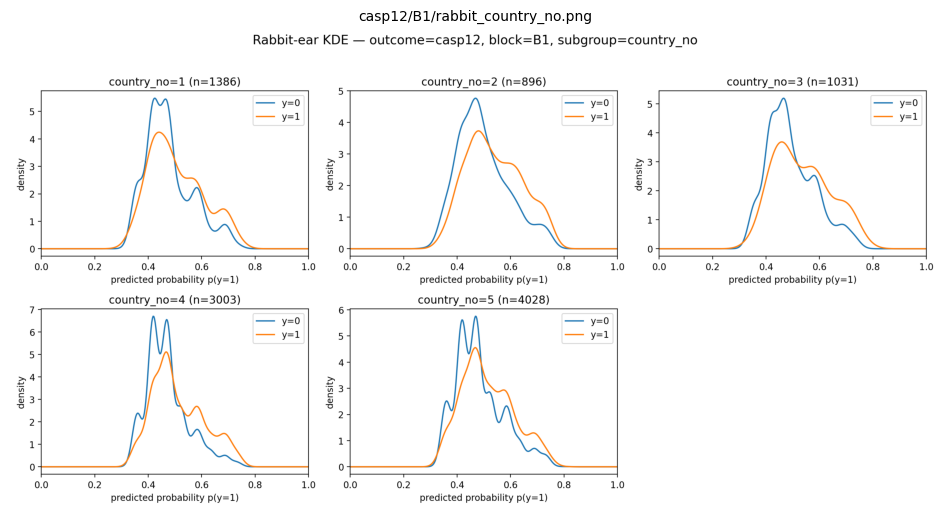

casp12/B1/rabbit_edu_lv.png


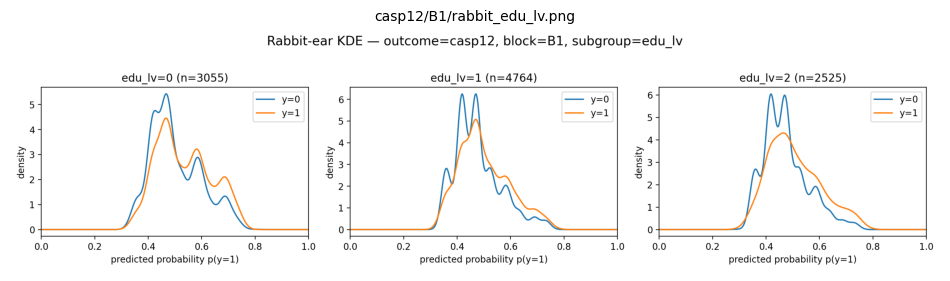

casp12/B1/rabbit_gender.png


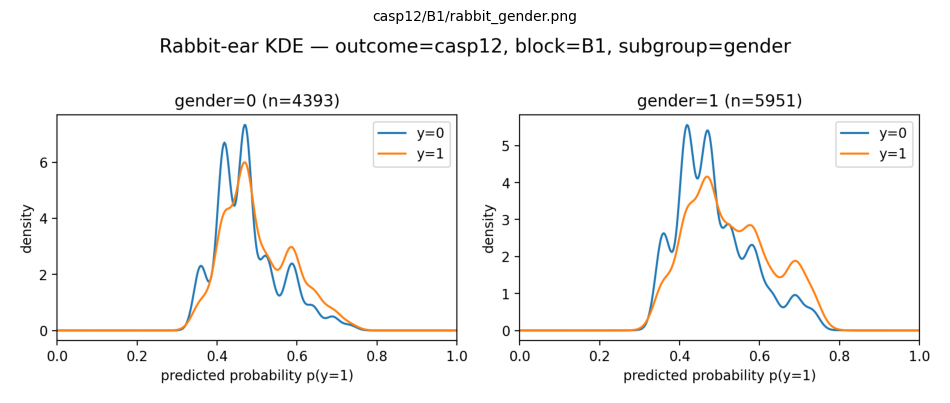

casp12/B1/rabbit_region.png


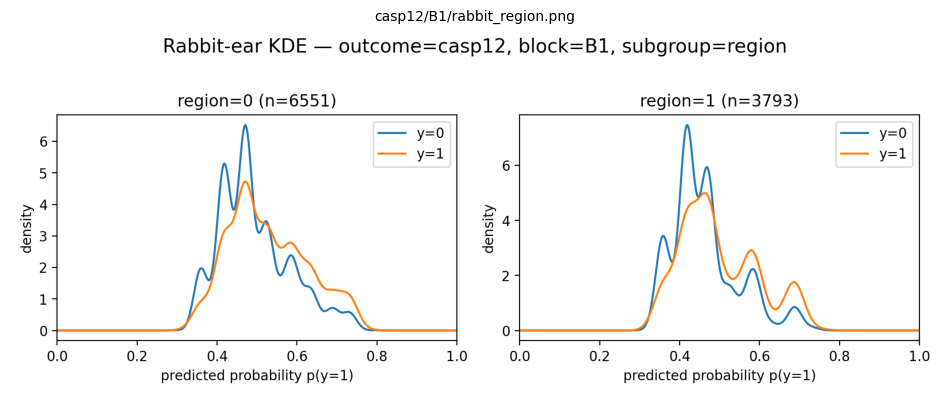

casp12/B1/rabbit_ses_q.png


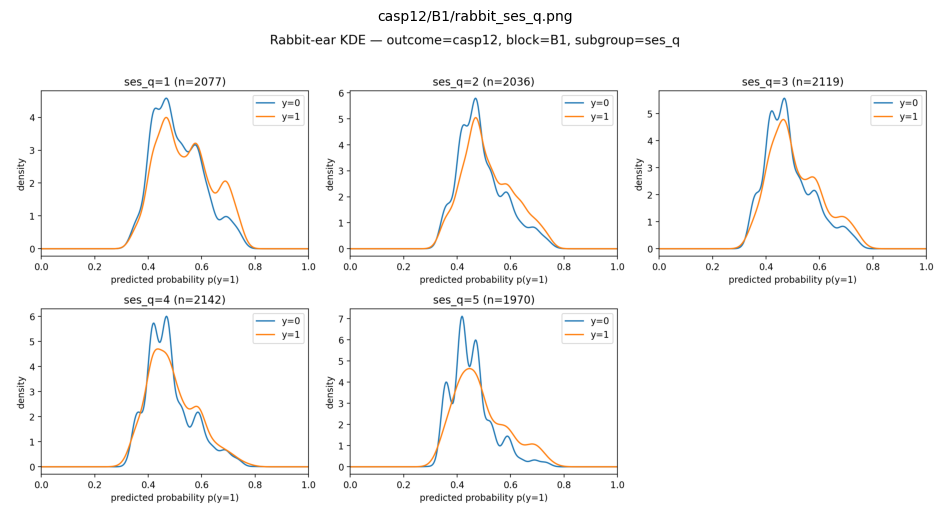

casp12/B2/rabbit_country_no.png


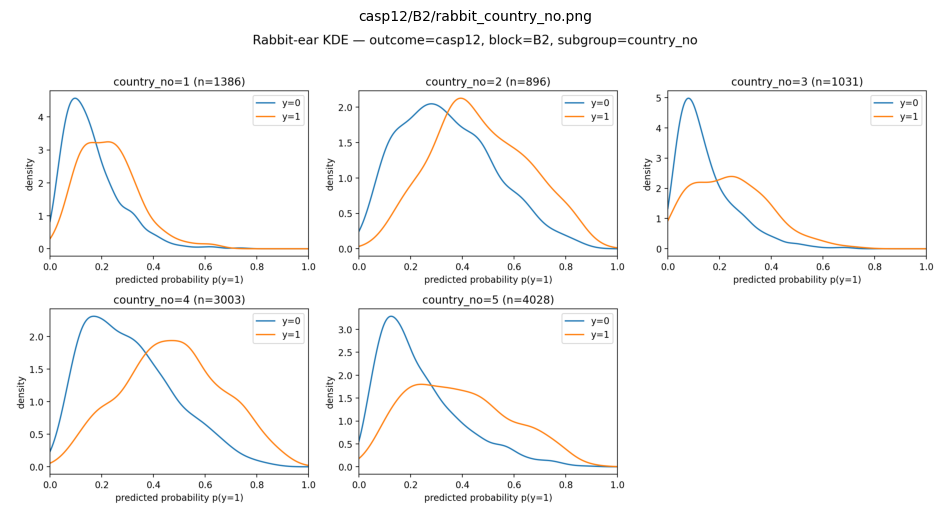

casp12/B2/rabbit_edu_lv.png


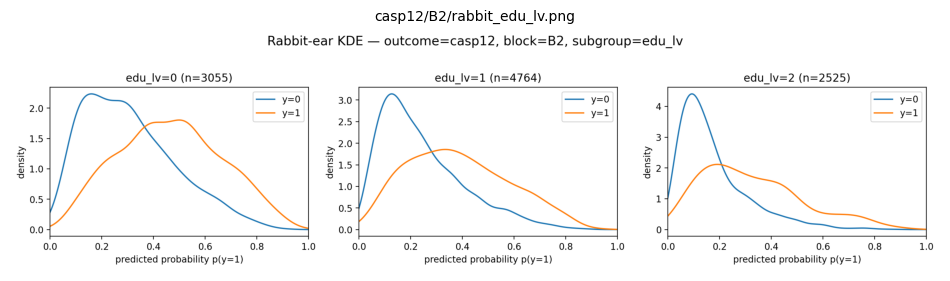

casp12/B2/rabbit_gender.png


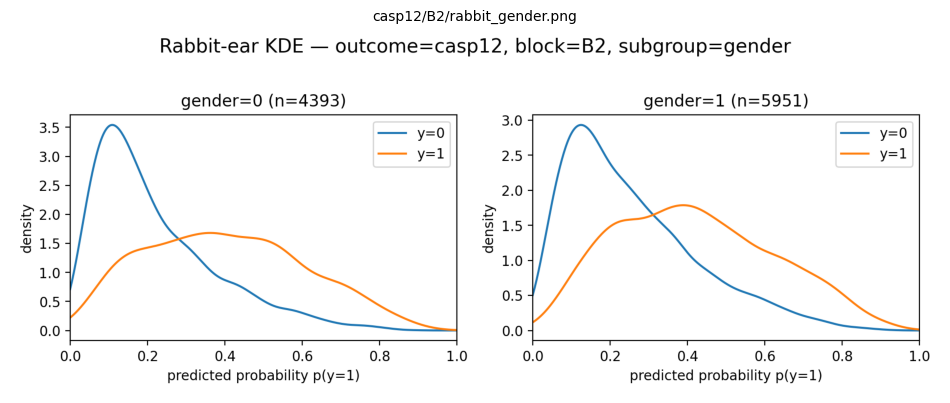

casp12/B2/rabbit_region.png


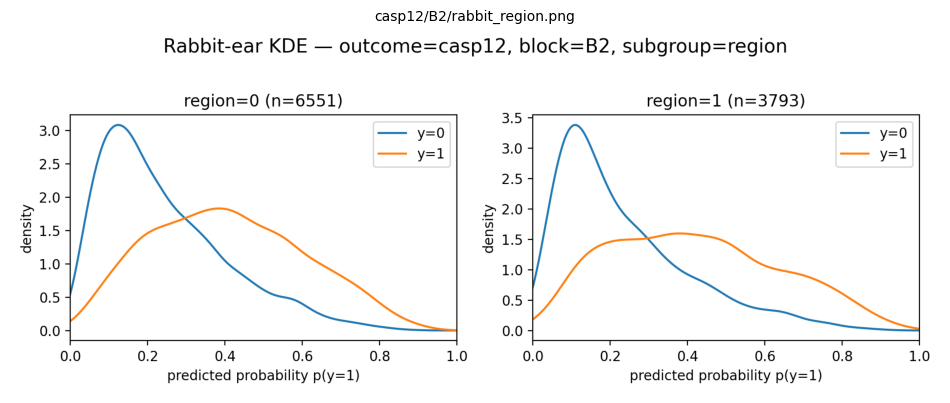

casp12/B2/rabbit_ses_q.png


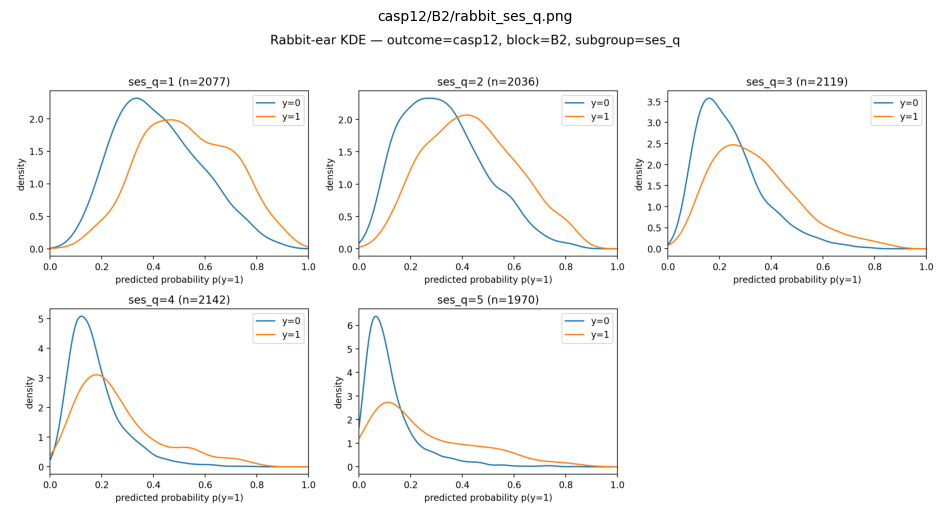

casp12/B3/rabbit_country_no.png


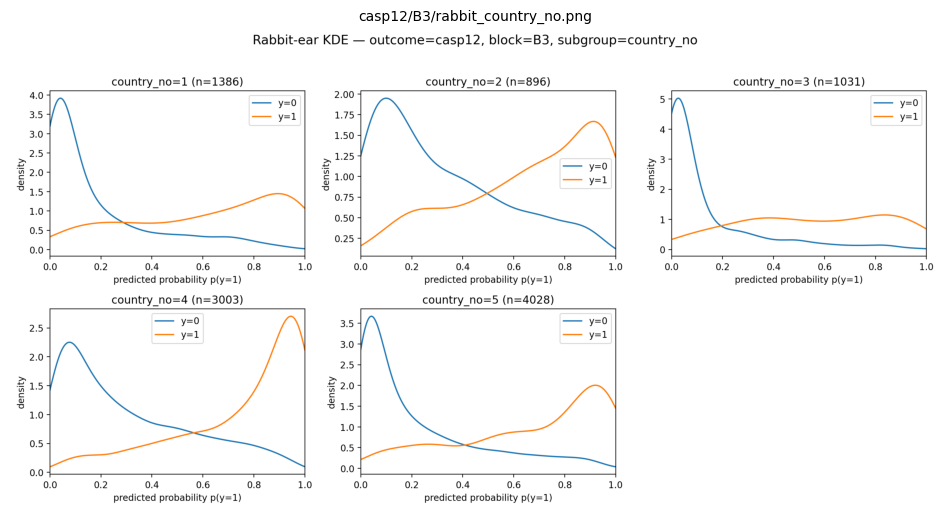

casp12/B3/rabbit_edu_lv.png


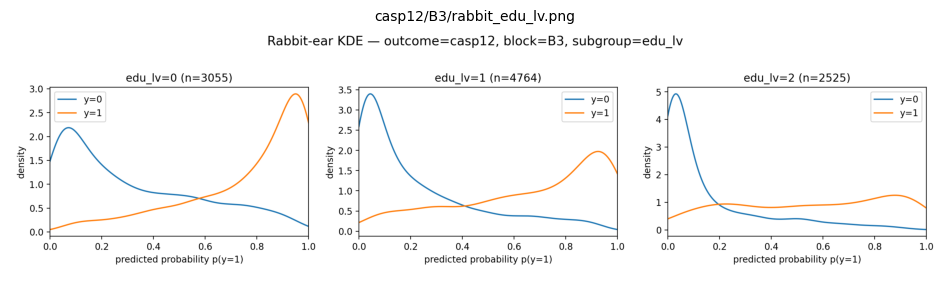

casp12/B3/rabbit_gender.png


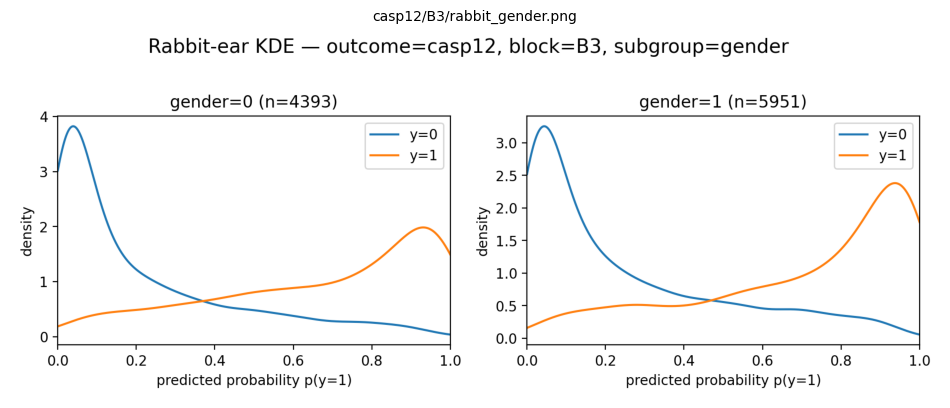

casp12/B3/rabbit_region.png


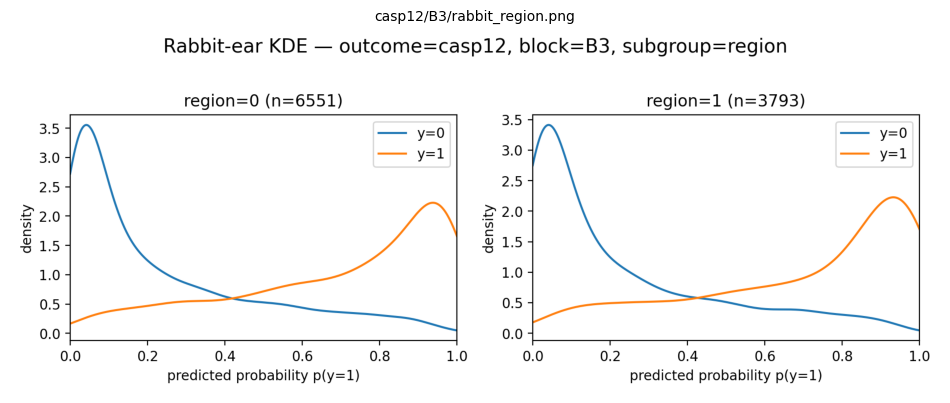

casp12/B3/rabbit_ses_q.png


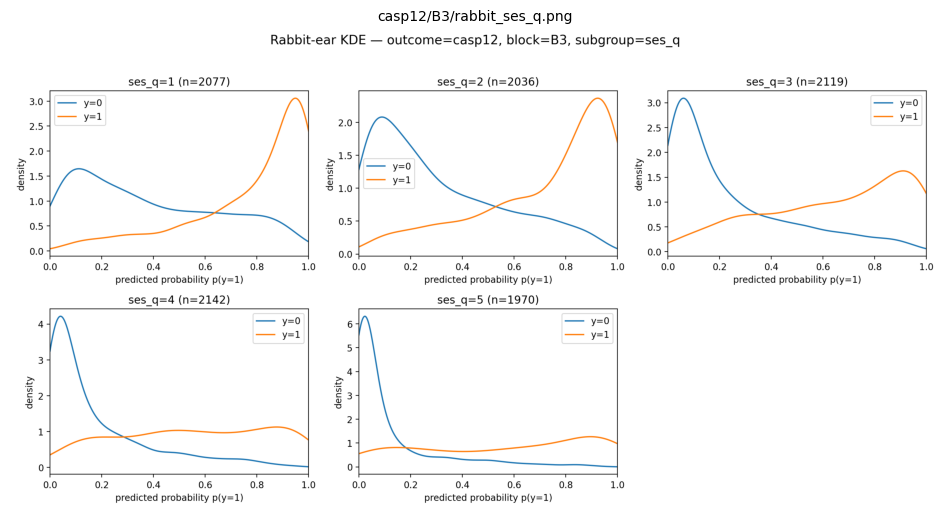

eurod/B1/rabbit_country_no.png


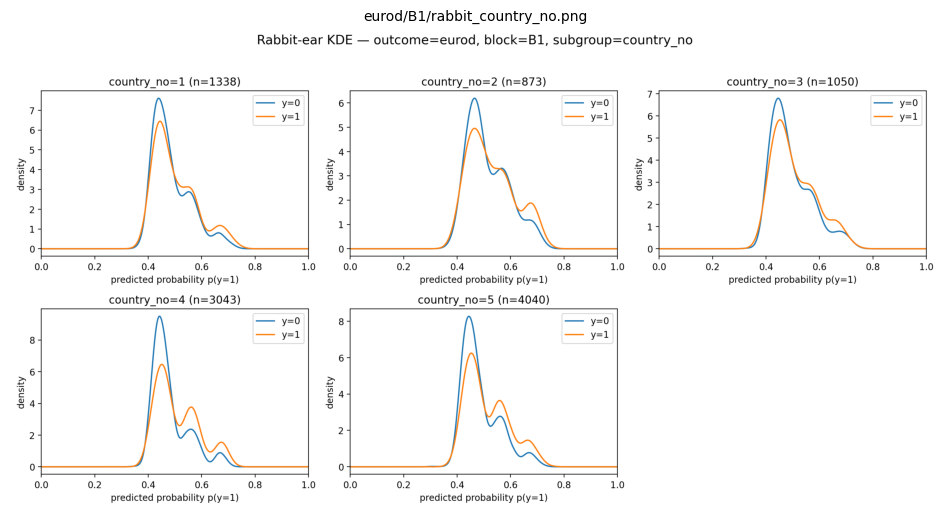

eurod/B1/rabbit_edu_lv.png


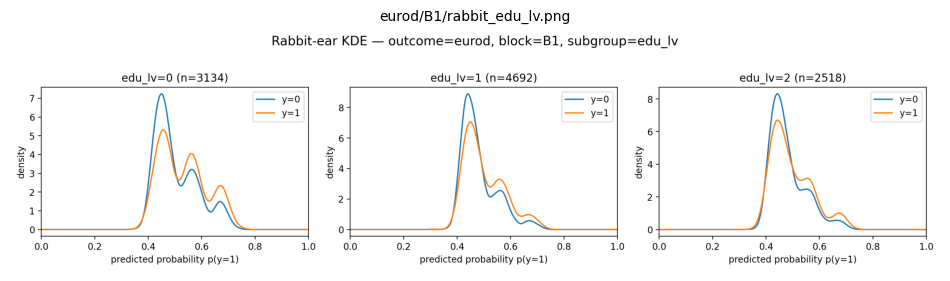

eurod/B1/rabbit_gender.png


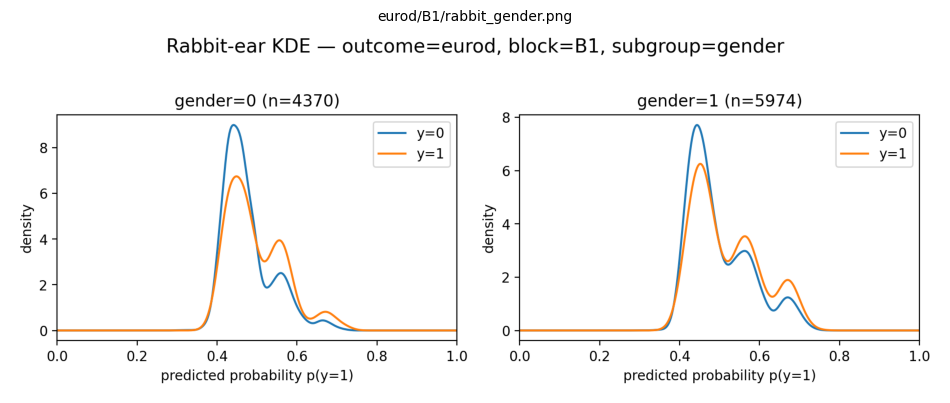

eurod/B1/rabbit_region.png


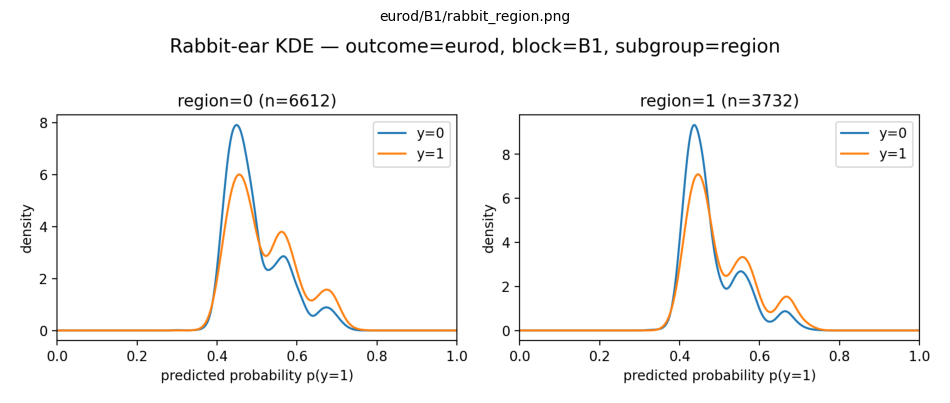

eurod/B1/rabbit_ses_q.png


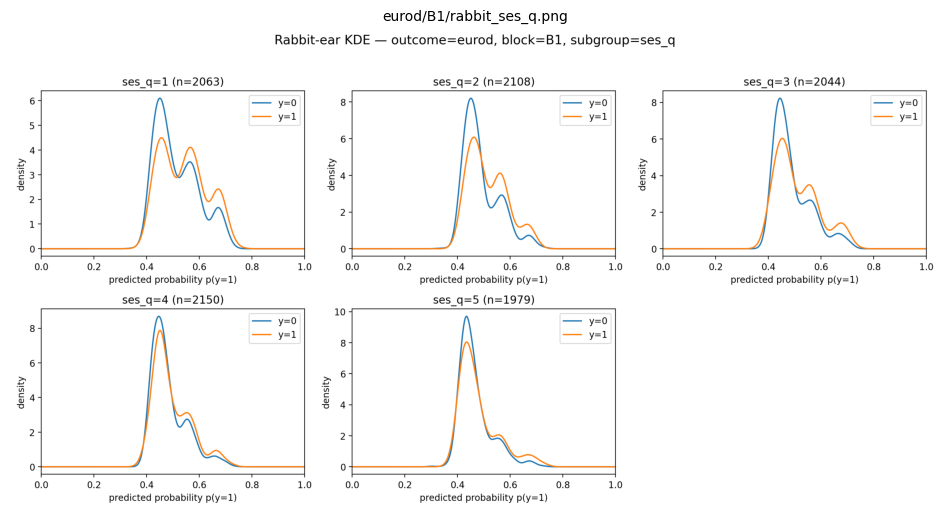

eurod/B2/rabbit_country_no.png


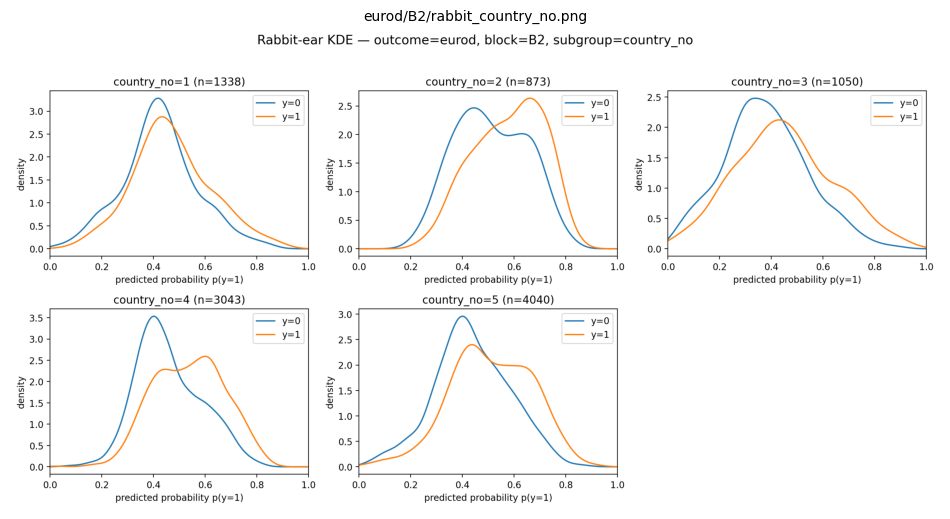

eurod/B2/rabbit_edu_lv.png


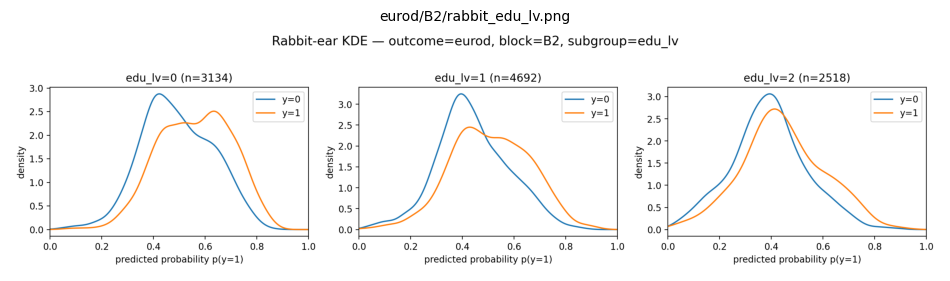

eurod/B2/rabbit_gender.png


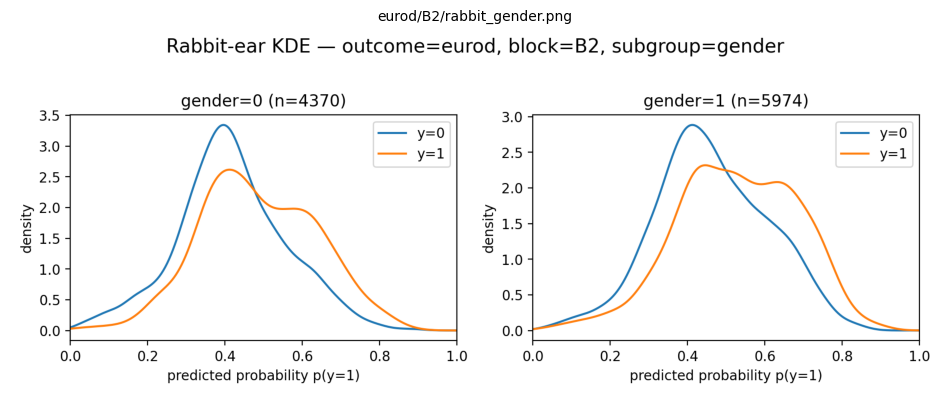

eurod/B2/rabbit_region.png


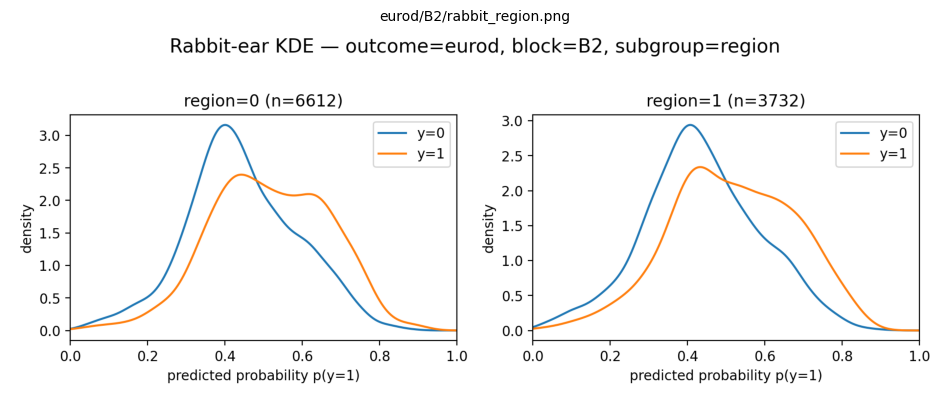

eurod/B2/rabbit_ses_q.png


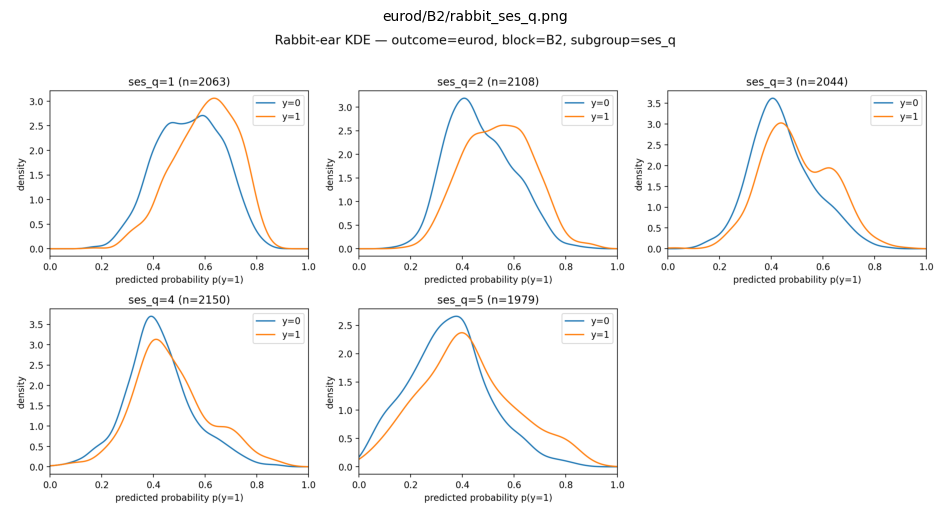

eurod/B3/rabbit_country_no.png


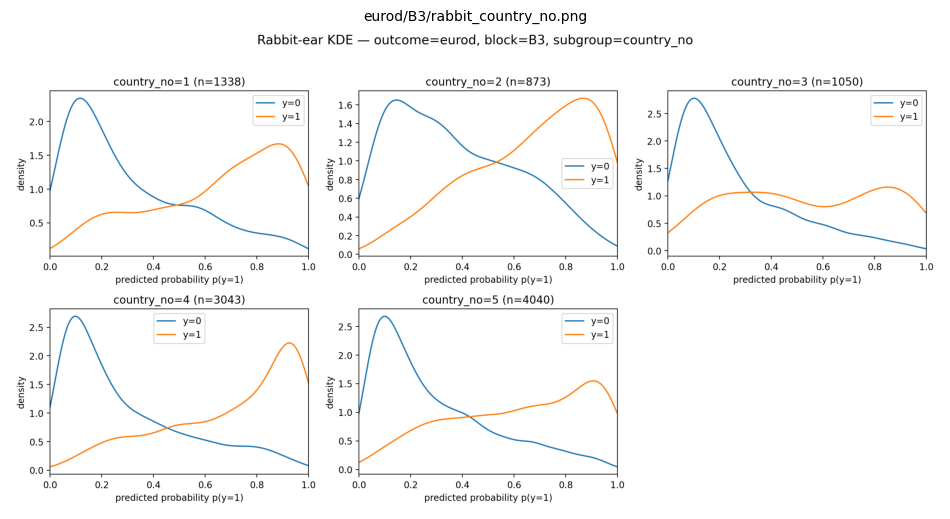

eurod/B3/rabbit_edu_lv.png


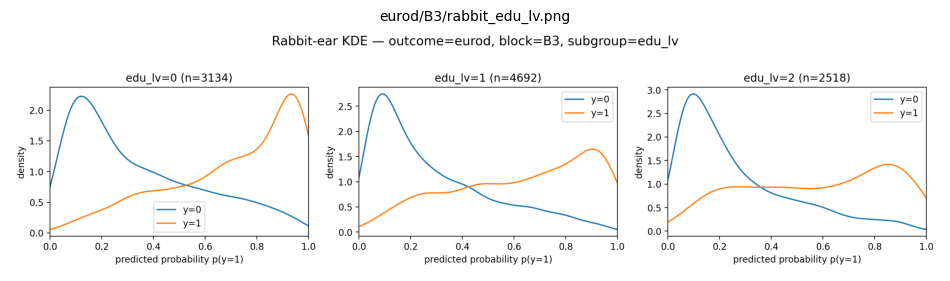

eurod/B3/rabbit_gender.png


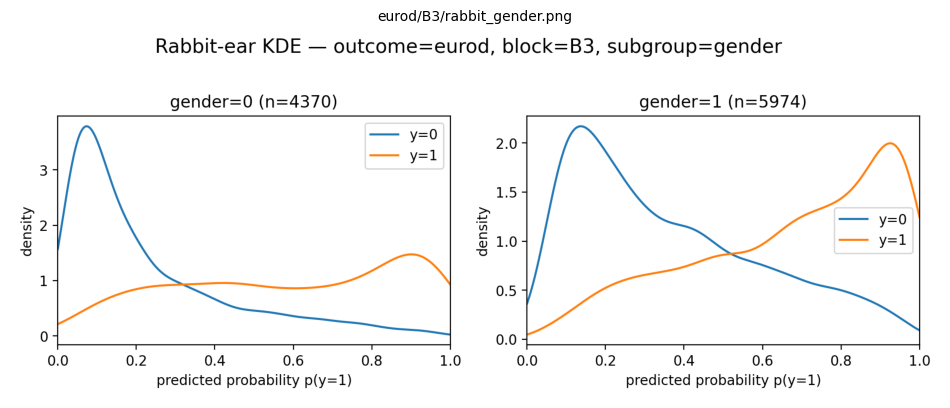

eurod/B3/rabbit_region.png


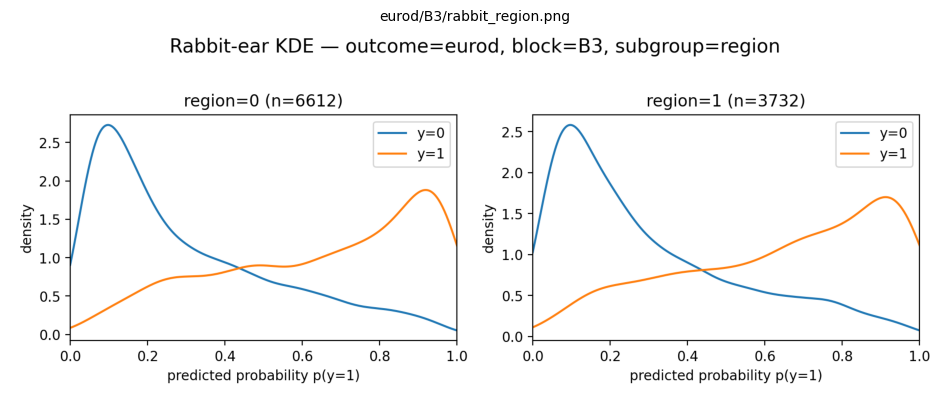

eurod/B3/rabbit_ses_q.png


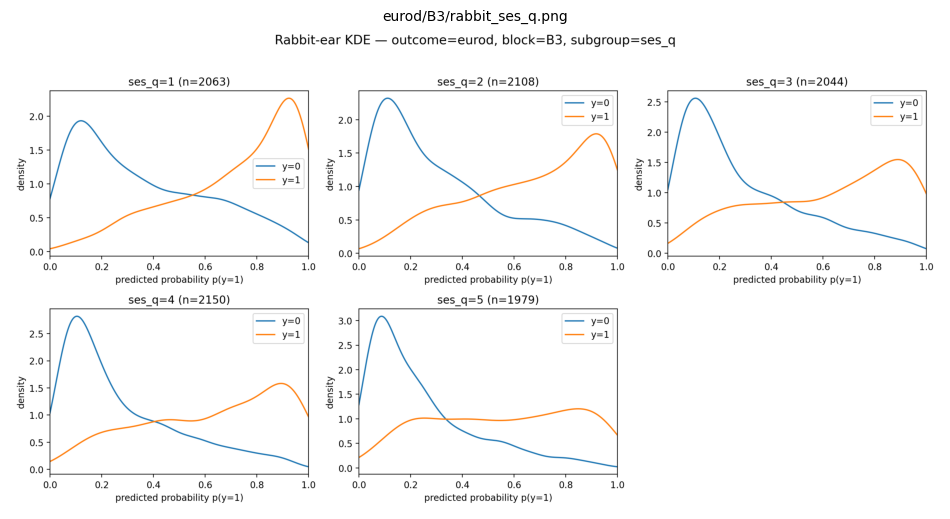

life_satisfaction/B1/rabbit_country_no.png


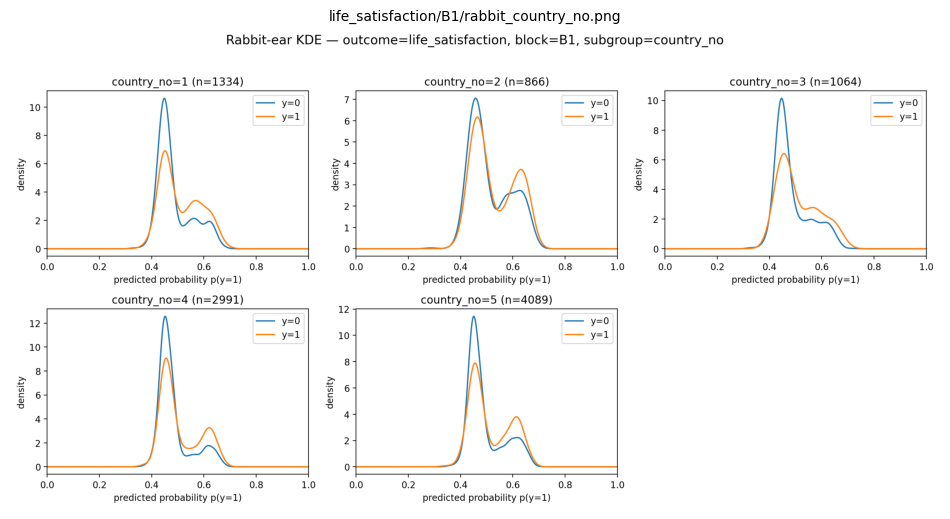

life_satisfaction/B1/rabbit_edu_lv.png


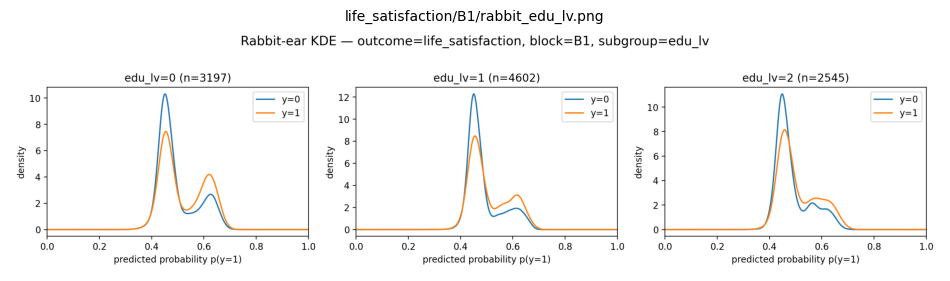

life_satisfaction/B1/rabbit_gender.png


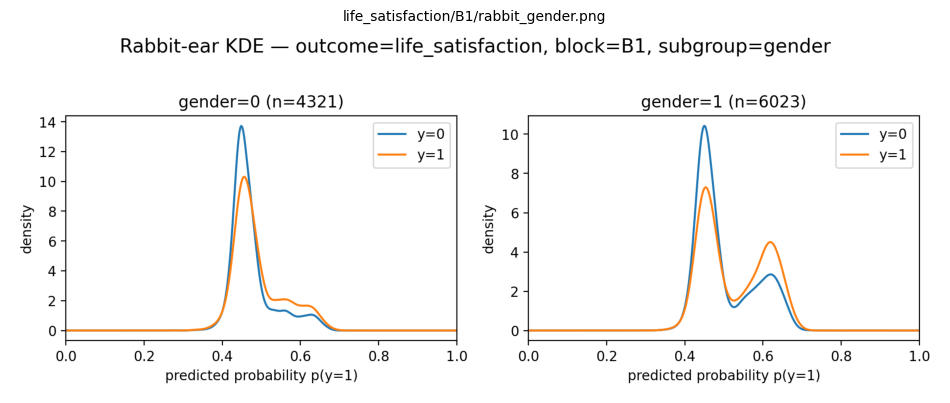

life_satisfaction/B1/rabbit_region.png


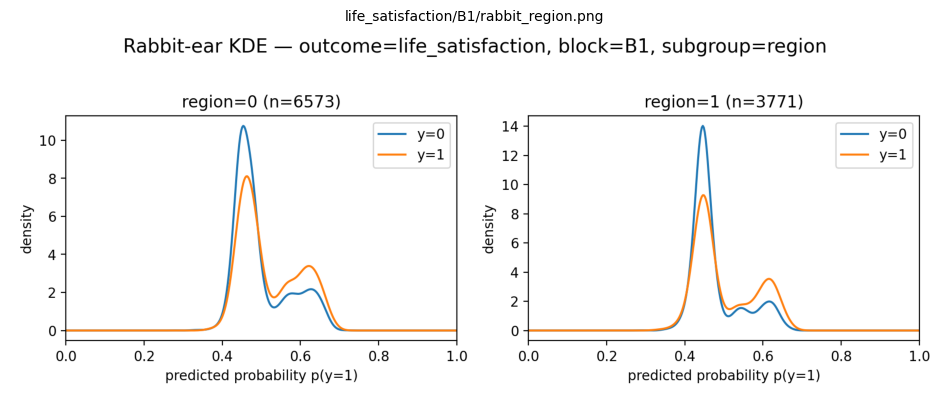

life_satisfaction/B1/rabbit_ses_q.png


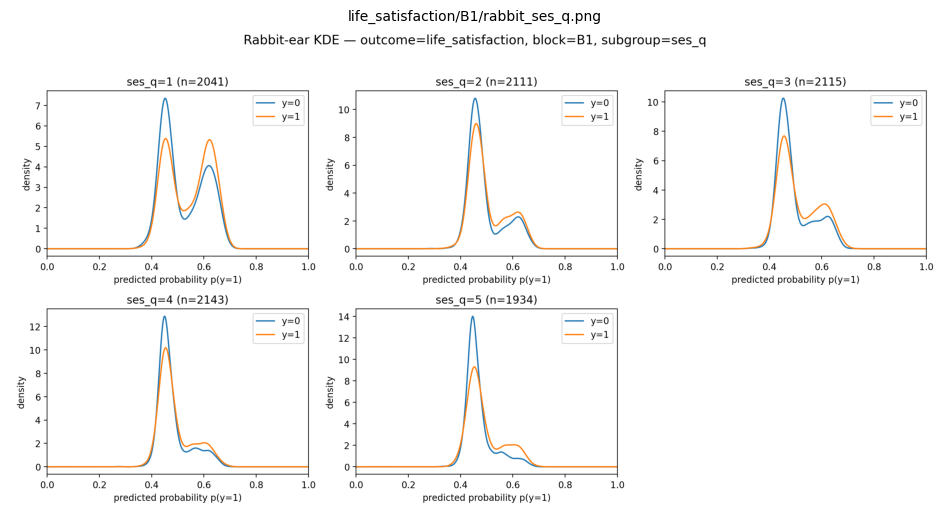

life_satisfaction/B2/rabbit_country_no.png


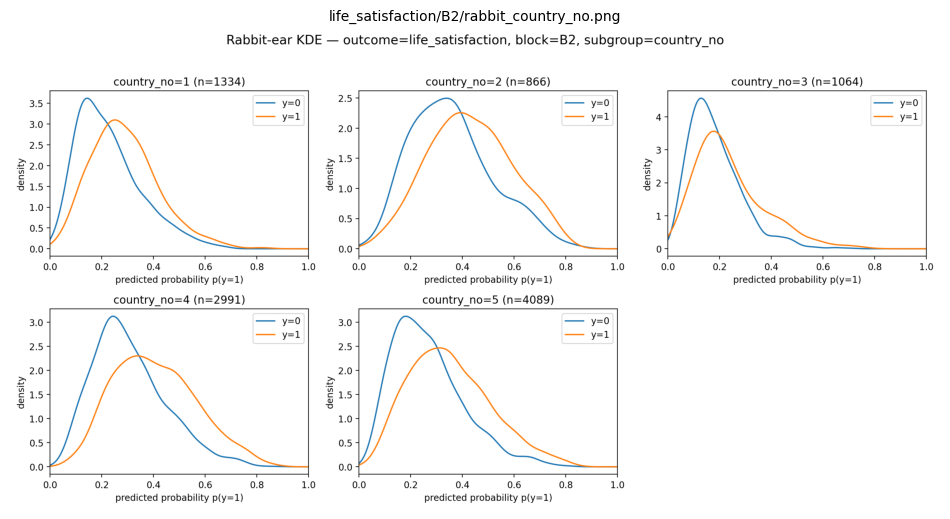

life_satisfaction/B2/rabbit_edu_lv.png


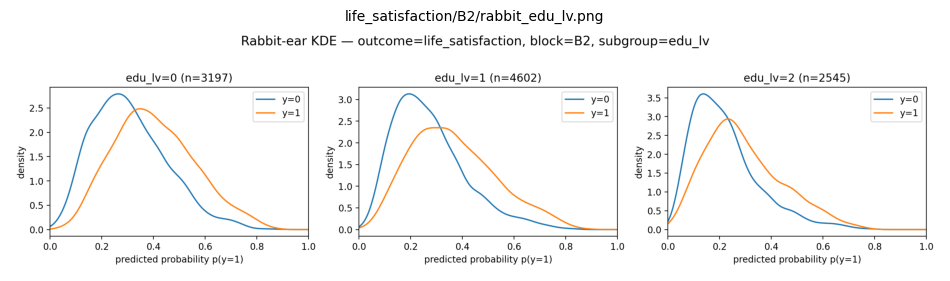

life_satisfaction/B2/rabbit_gender.png


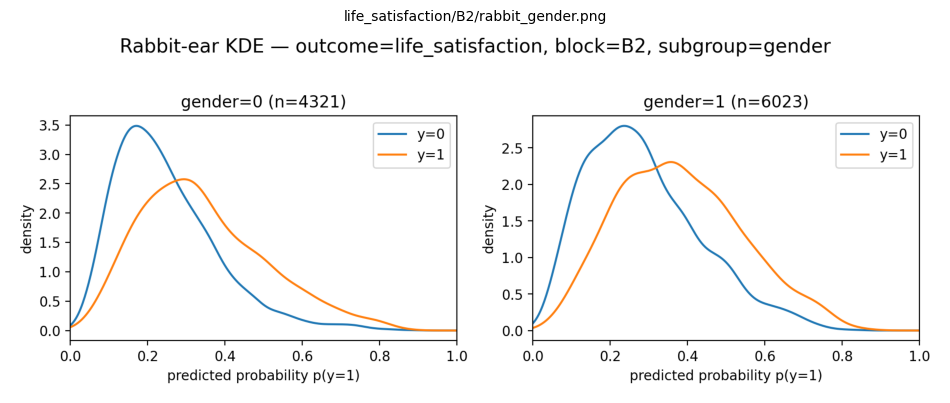

life_satisfaction/B2/rabbit_region.png


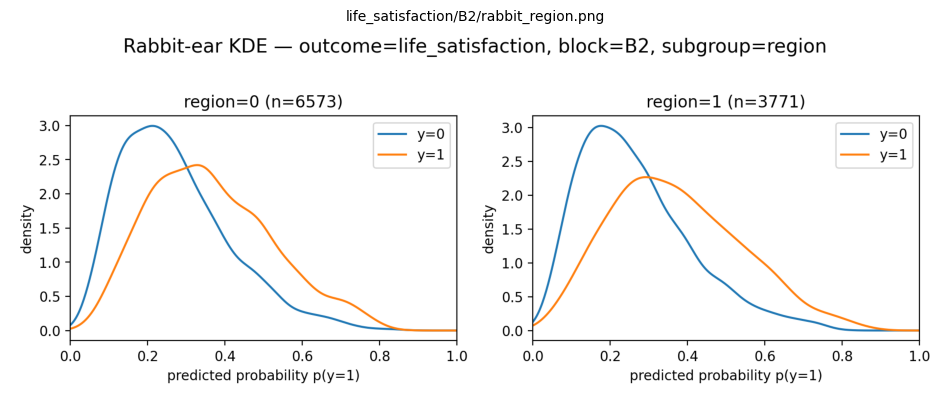

life_satisfaction/B2/rabbit_ses_q.png


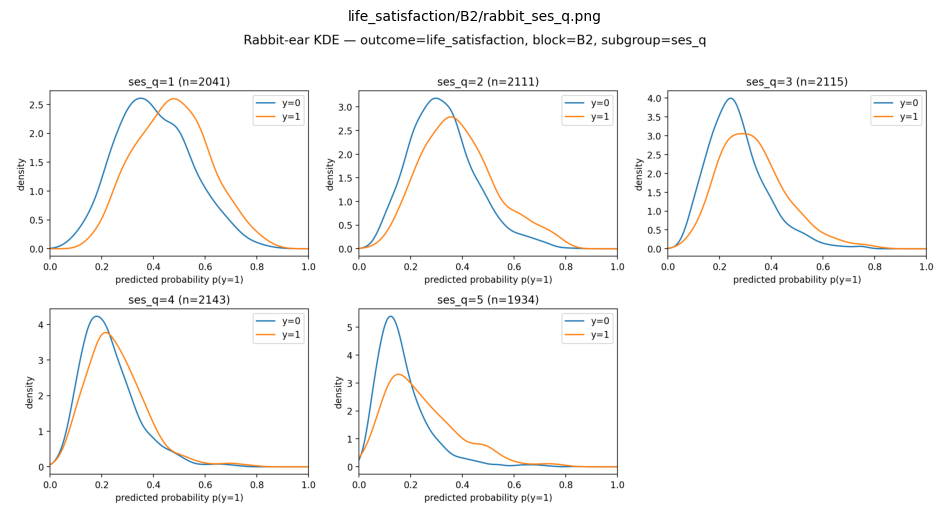

life_satisfaction/B3/rabbit_country_no.png


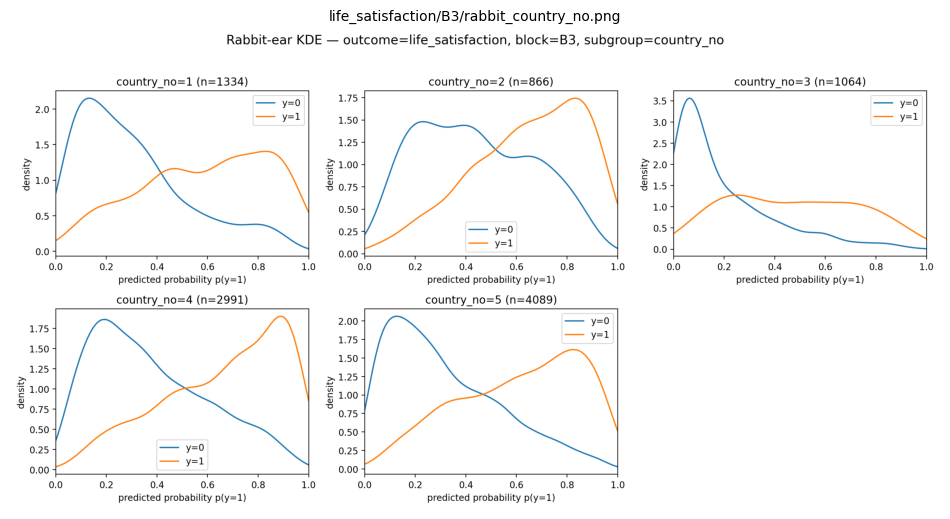

life_satisfaction/B3/rabbit_edu_lv.png


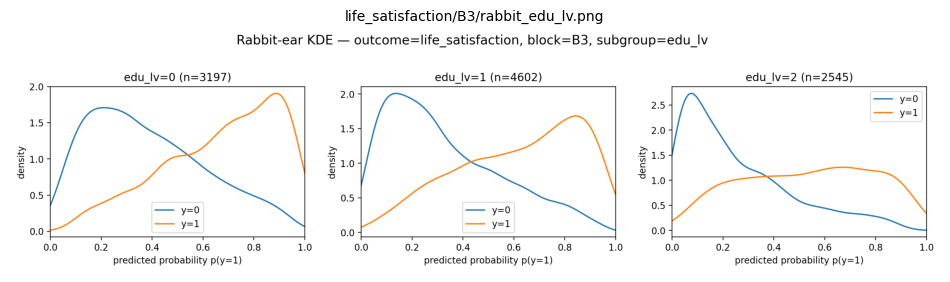

life_satisfaction/B3/rabbit_gender.png


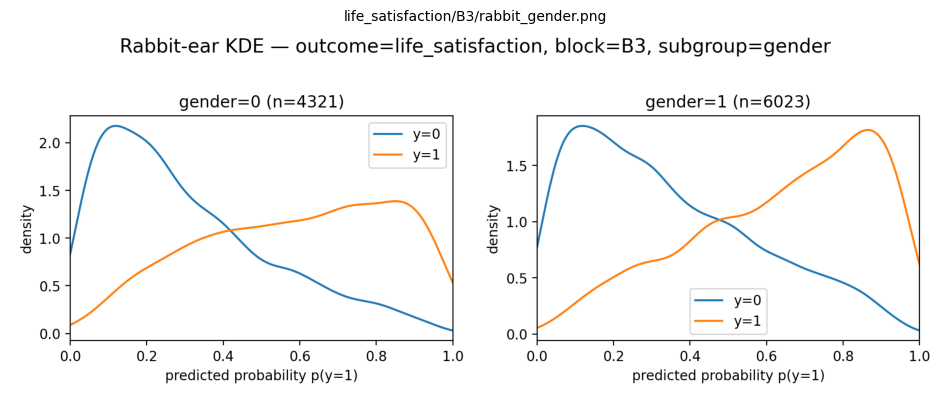

life_satisfaction/B3/rabbit_region.png


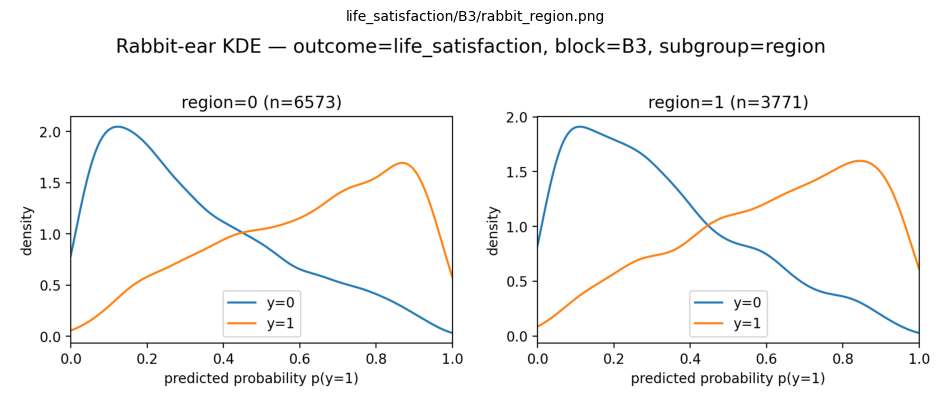

life_satisfaction/B3/rabbit_ses_q.png


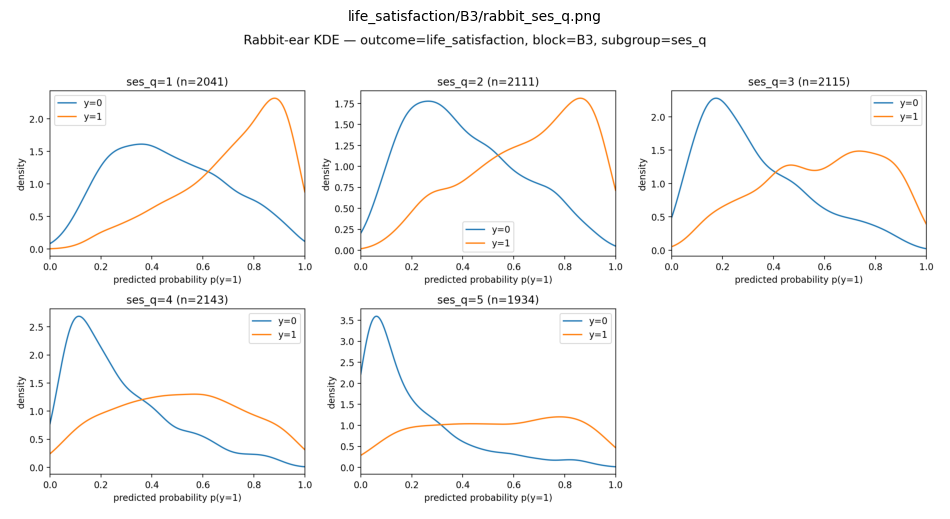

In [ ]:
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

# Find all rabbit-ear plots
plot_paths = sorted(glob(os.path.join(OUTDIR, "**", "rabbit_*.png"), recursive=True))

print(f"Found {len(plot_paths)} rabbit-ear plots.\n")

if len(plot_paths) == 0:
    print("No plots found. Make sure Cell 13 ran successfully and scipy is available.")
else:
    for p in plot_paths:
        # Print the relative path as a title so you know what you’re seeing
        rel = os.path.relpath(p, OUTDIR)
        print(rel)

        img = Image.open(p)
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(rel, fontsize=10)
        plt.show()

In [ ]:
import os
import json
import numpy as np
import pandas as pd

OUTDIR = "outputs_qol_fairness"
SUBGROUP_VARS = ["country_no", "ses_q", "edu_lv", "gender", "region"]
MIN_N = 200
MIN_Y = 30

# Based on your summary files / best_models_all_runs.csv
PRIMARY = {
    "eurod": {"block": "B3", "model": "xgb"},
    "life_satisfaction": {"block": "B3", "model": "xgb"},
    "casp12": {"block": "B3", "model": "lgbm"},   # or set to "xgb" if you want one model family
}

def load_pred(outcome_name: str, block: str):
    run_dir = os.path.join(OUTDIR, outcome_name, block)
    pred_path = os.path.join(run_dir, "pred_test.csv")
    info_path = os.path.join(run_dir, "best_model.json")
    if not os.path.exists(pred_path):
        raise FileNotFoundError(pred_path)
    pred_df = pd.read_csv(pred_path)
    info = json.load(open(info_path, "r"))
    return pred_df, info, run_dir

def valid_cats(pred_df: pd.DataFrame, group_col: str):
    g = pred_df.groupby(group_col)["y_true"].agg(n="count", y1="sum")
    g["y0"] = g["n"] - g["y1"]
    ok = g[(g["n"]>=MIN_N) & (g["y1"]>=MIN_Y) & (g["y0"]>=MIN_Y)].index.tolist()
    return ok, g.reset_index()

print("Primary runs locked:")
for k,v in PRIMARY.items():
    print(k, v)

Primary runs locked:
eurod {'block': 'B3', 'model': 'xgb'}
life_satisfaction {'block': 'B3', 'model': 'xgb'}
casp12 {'block': 'B3', 'model': 'lgbm'}


In [ ]:

def safe_auc(y, p):
    if len(np.unique(y)) < 2:
        return np.nan, np.nan
    return roc_auc_score(y, p), average_precision_score(y, p)

rows = []

for outcome_name, cfg in PRIMARY.items():
    pred_df, info, run_dir = load_pred(outcome_name, cfg["block"])
    y = pred_df["y_true"].values
    p = pred_df["p_hat"].values

    overall_roc, overall_pr = safe_auc(y, p)

    # subgroup gaps
    gaps = {}
    for gcol in SUBGROUP_VARS:
        ok, _counts = valid_cats(pred_df, gcol)
        if len(ok) == 0:
            gaps[f"{gcol}_roc_gap"] = np.nan
            gaps[f"{gcol}_pr_gap"]  = np.nan
            continue

        per_roc = []
        per_pr = []
        for cat in ok:
            sub = pred_df[pred_df[gcol]==cat]
            r, pr = safe_auc(sub["y_true"].values, sub["p_hat"].values)
            per_roc.append(r); per_pr.append(pr)

        gaps[f"{gcol}_roc_gap"] = np.nanmax(per_roc) - np.nanmin(per_roc)
        gaps[f"{gcol}_pr_gap"]  = np.nanmax(per_pr)  - np.nanmin(per_pr)

    rows.append({
        "outcome": outcome_name,
        "block": cfg["block"],
        "best_model": info.get("best_model", ""),
        "test_roc_auc": overall_roc,
        "test_pr_auc": overall_pr,
        **gaps
    })

summary = pd.DataFrame(rows)
display(summary)
summary.to_csv(os.path.join(OUTDIR, "PRIMARY_summary_overall_and_gaps.csv"), index=False)
print("Saved:", os.path.join(OUTDIR, "PRIMARY_summary_overall_and_gaps.csv"))

outcome block best_model  test_roc_auc  test_pr_auc  \
0              eurod    B3        xgb      0.833684     0.669246   
1  life_satisfaction    B3        xgb      0.809439     0.656825   
2             casp12    B3       lgbm      0.884595     0.785658   

   country_no_roc_gap  country_no_pr_gap  ses_q_roc_gap  ses_q_pr_gap  \
0            0.081670           0.176076       0.024846      0.144202   
1            0.071826           0.293115       0.076764      0.246090   
2            0.086608           0.286393       0.033300      0.243689   

   edu_lv_roc_gap  edu_lv_pr_gap  gender_roc_gap  gender_pr_gap  \
0        0.030175       0.157428        0.040521       0.056796   
1        0.005903       0.137937        0.007308       0.071088   
2        0.012756       0.224163        0.011544       0.035607   

   region_roc_gap  region_pr_gap  
0        0.006171       0.016441  
1        0.000111       0.026367  
2        0.003331       0.015059

Saved: outputs_qol_fairness/PRIMARY_summary_overall_and_gaps.csv


Collected 15 plots into outputs_qol_fairness/PRIMARY_PLOTS


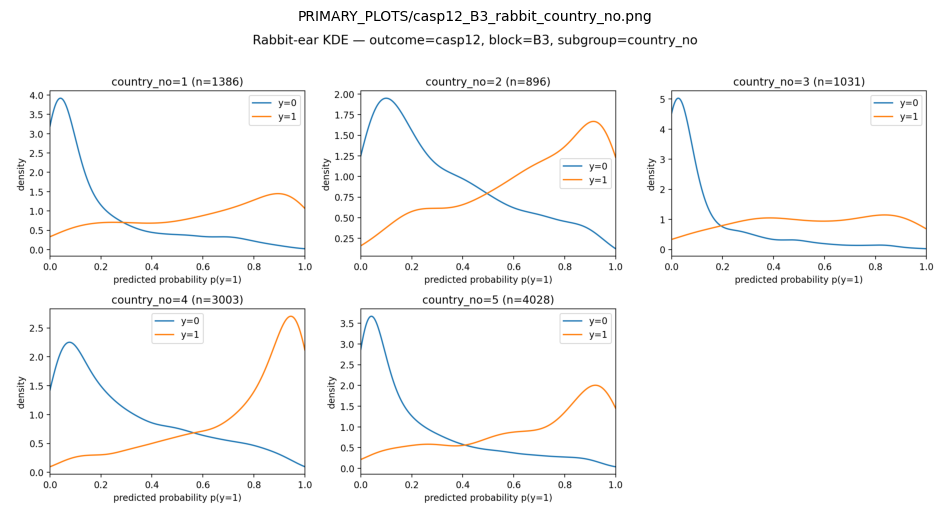

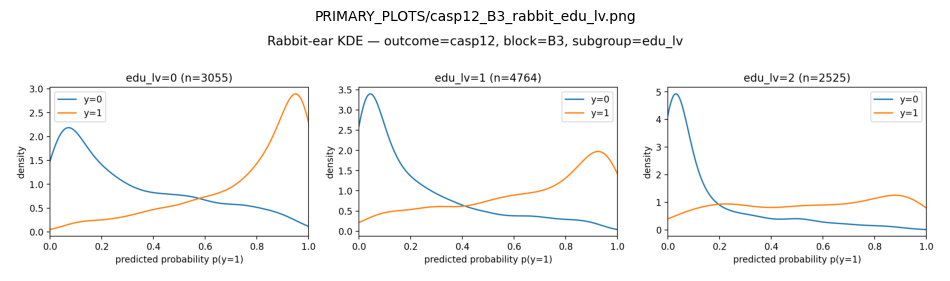

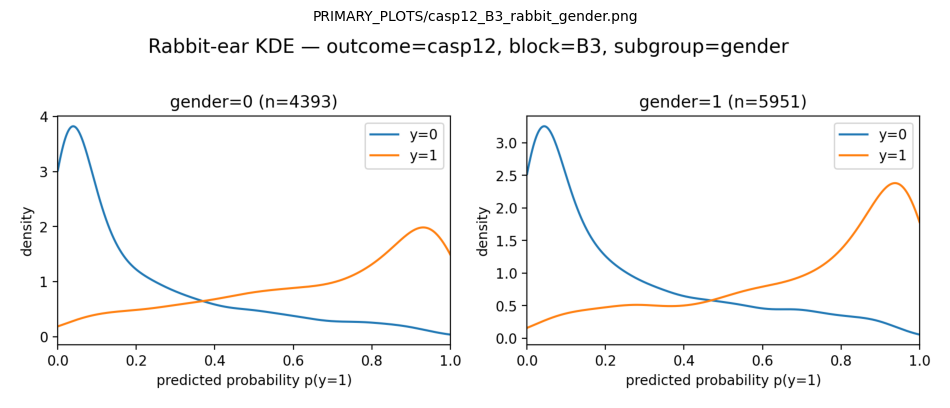

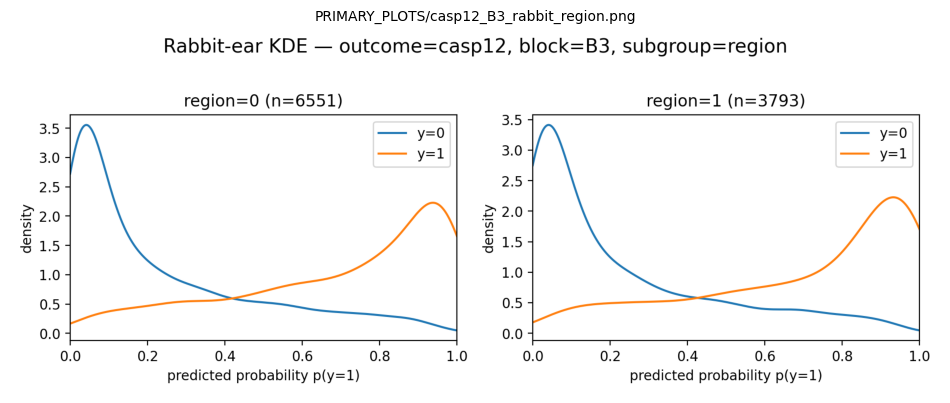

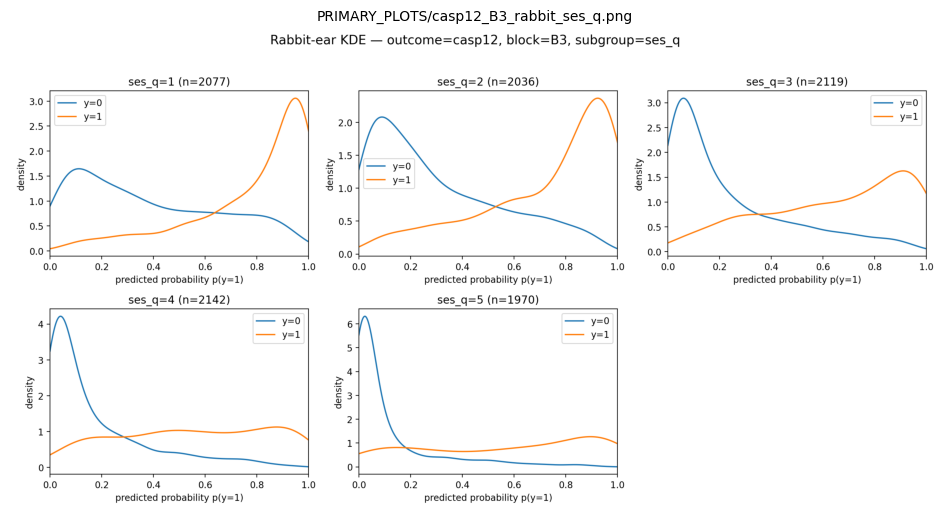

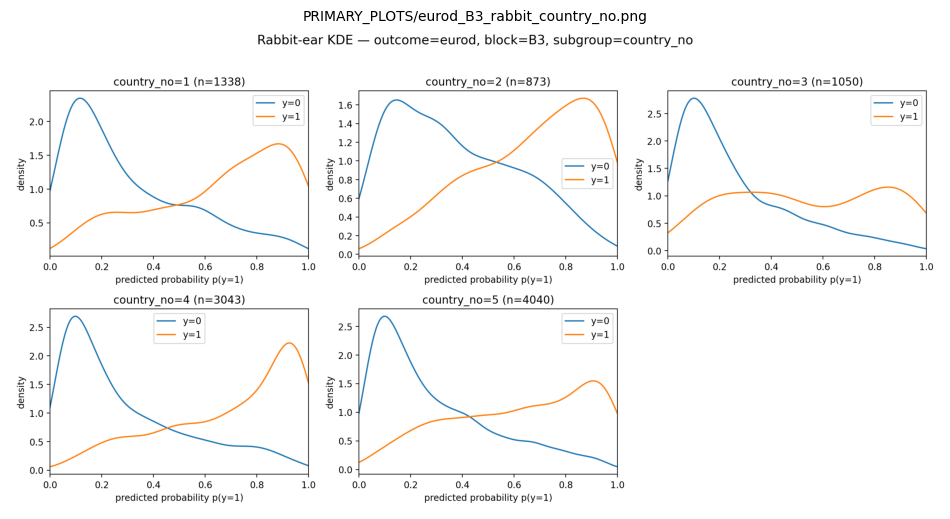

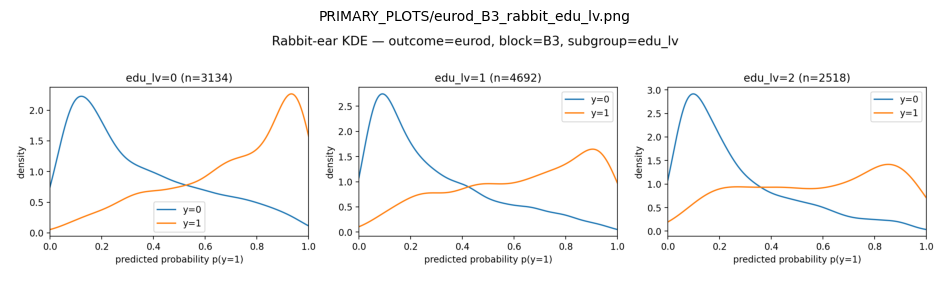

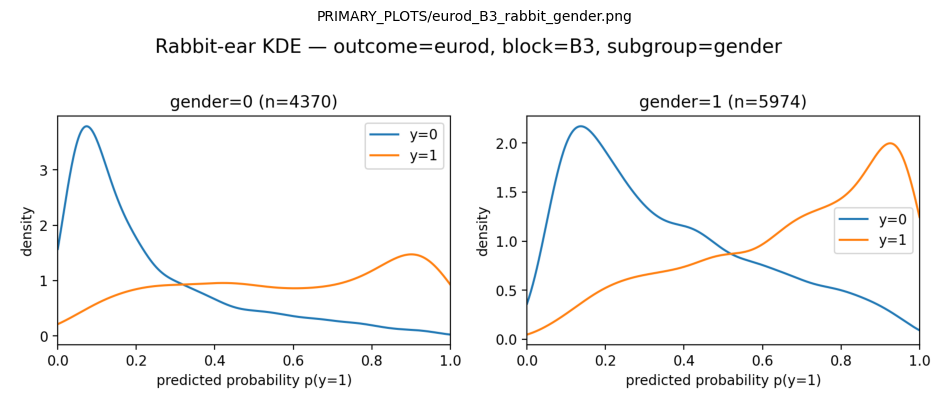

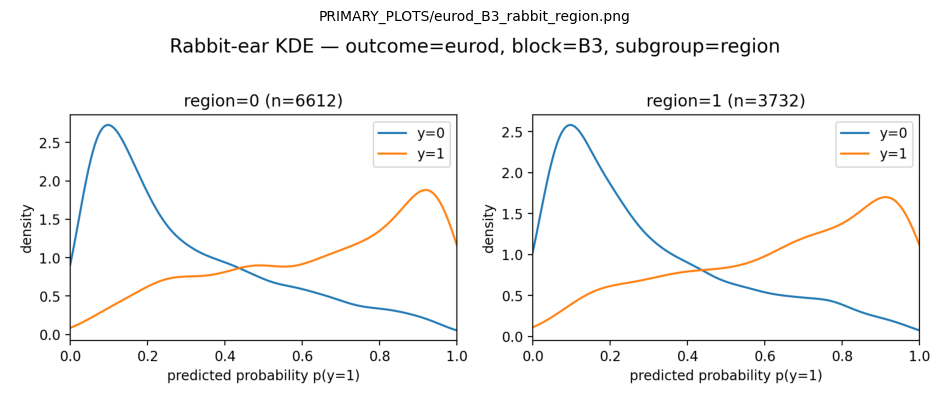

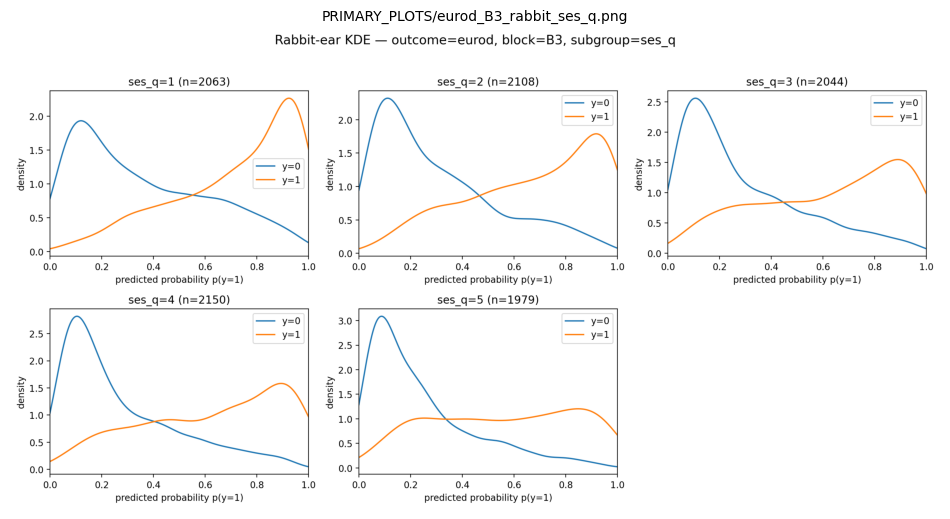

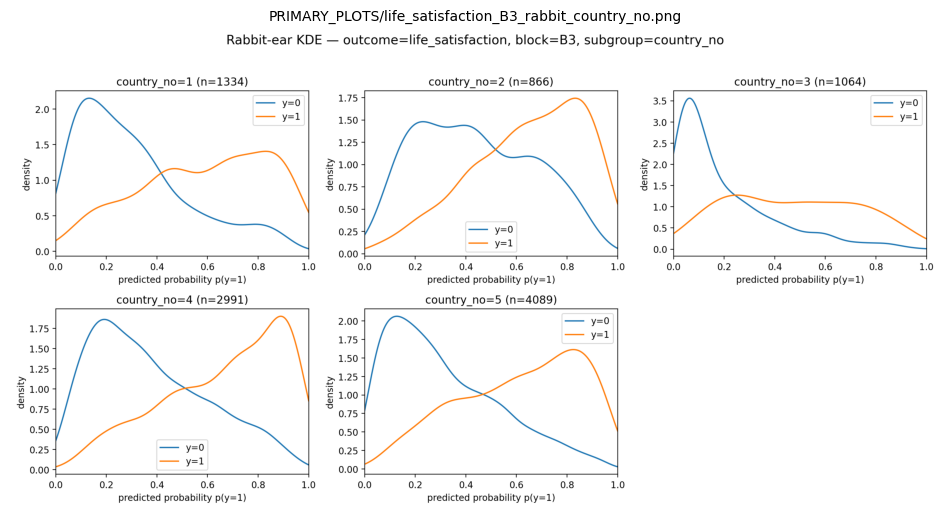

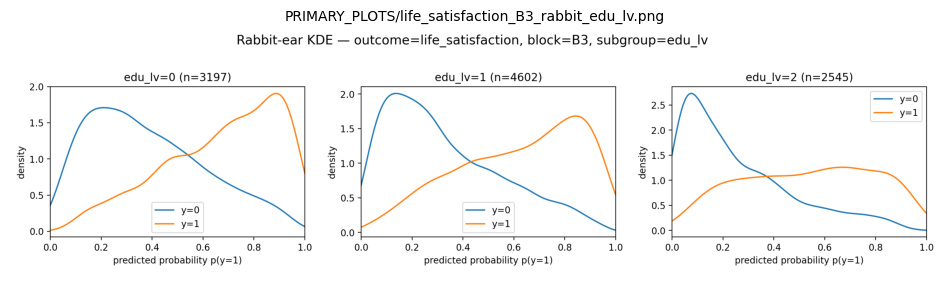

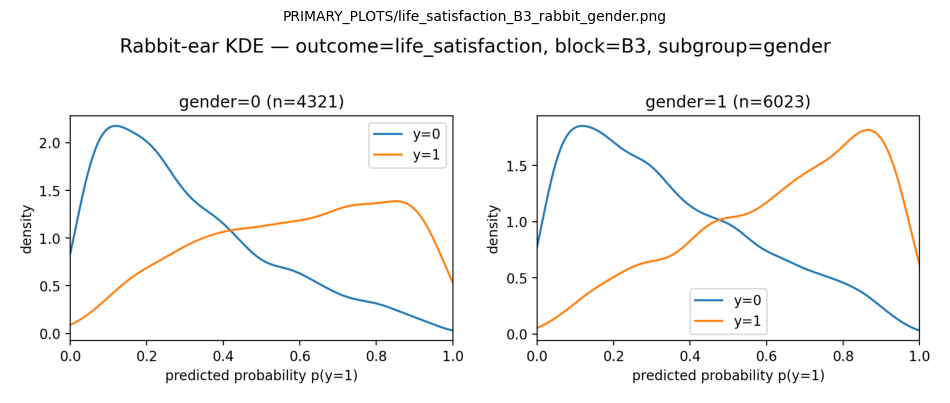

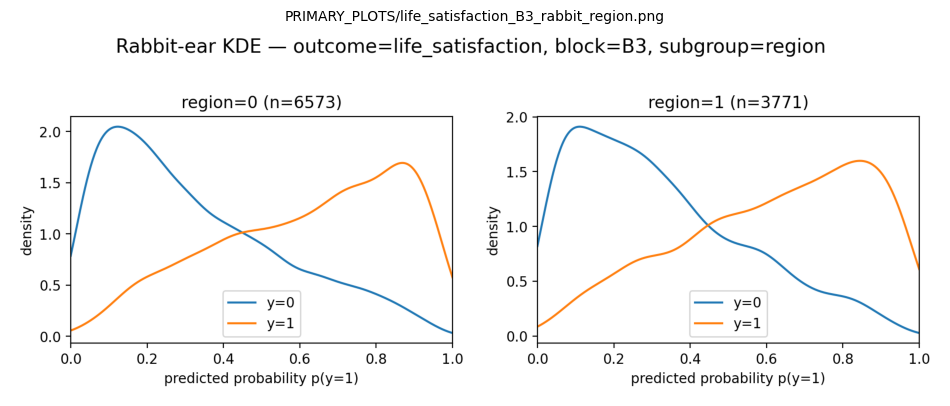

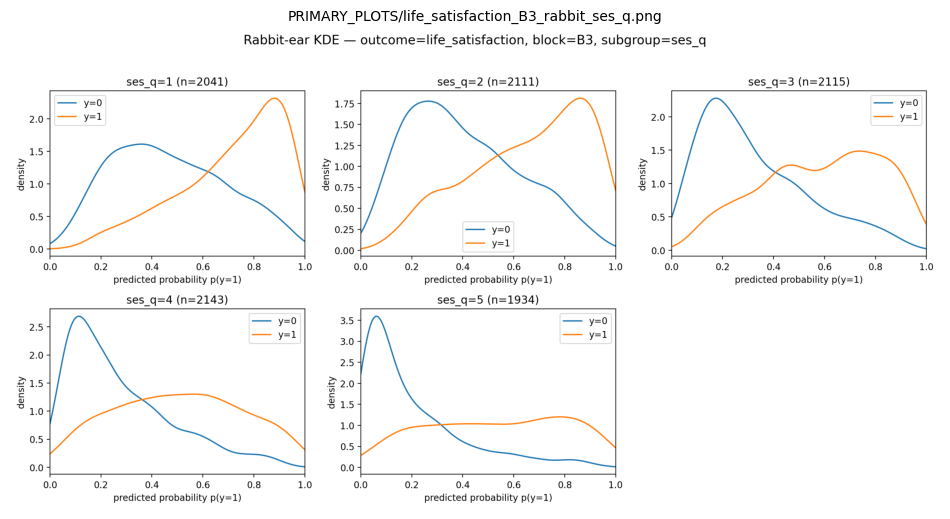

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Use the rabbit_*.png already saved in each run_dir (from Cell 13),
# and copy/display them in a single "PRIMARY_PLOTS" folder.
PRIMARY_PLOT_DIR = os.path.join(OUTDIR, "PRIMARY_PLOTS")
os.makedirs(PRIMARY_PLOT_DIR, exist_ok=True)

def copy_plot(src, dst):
    # simple byte copy
    with open(src, "rb") as fsrc:
        b = fsrc.read()
    with open(dst, "wb") as fdst:
        fdst.write(b)

plot_index = []

for outcome_name, cfg in PRIMARY.items():
    pred_df, info, run_dir = load_pred(outcome_name, cfg["block"])
    for gcol in SUBGROUP_VARS:
        src = os.path.join(run_dir, f"rabbit_{gcol}.png")
        if not os.path.exists(src):
            continue
        dst = os.path.join(PRIMARY_PLOT_DIR, f"{outcome_name}_B3_rabbit_{gcol}.png")
        copy_plot(src, dst)
        plot_index.append(dst)

print(f"Collected {len(plot_index)} plots into {PRIMARY_PLOT_DIR}")

# display all of them inline
for p in sorted(plot_index):
    rel = os.path.relpath(p, OUTDIR)
    img = Image.open(p)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(rel, fontsize=10)
    plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np

OUTDIR = "outputs_qol_fairness"
PRIMARY = {
    "eurod": {"block": "B3"},
    "life_satisfaction": {"block": "B3"},
    "casp12": {"block": "B3"},
}
SUBGROUP_VARS = ["country_no", "ses_q", "edu_lv", "gender", "region"]

def summarize_subgroup_extremes(outcome, block, gcol):
    path = os.path.join(OUTDIR, outcome, block, f"subgroup_metrics_{gcol}.csv")
    if not os.path.exists(path):
        return None
    d = pd.read_csv(path)
    if d.empty:
        return None
    d = d.sort_values("pr_auc")
    worst = d.iloc[0]
    best = d.iloc[-1]
    return {
        "outcome": outcome, "block": block, "group": gcol,
        "worst_cat": worst[gcol], "worst_n": int(worst["n"]),
        "worst_roc": float(worst["roc_auc"]), "worst_pr": float(worst["pr_auc"]),
        "best_cat": best[gcol], "best_n": int(best["n"]),
        "best_roc": float(best["roc_auc"]), "best_pr": float(best["pr_auc"]),
        "roc_gap": float(best["roc_auc"] - worst["roc_auc"]),
        "pr_gap": float(best["pr_auc"] - worst["pr_auc"]),
    }

rows = []
for outcome, cfg in PRIMARY.items():
    for gcol in SUBGROUP_VARS:
        s = summarize_subgroup_extremes(outcome, cfg["block"], gcol)
        if s: rows.append(s)

extremes = pd.DataFrame(rows)
display(extremes.sort_values(["outcome","pr_gap"], ascending=[True,False]))
extremes.to_csv(os.path.join(OUTDIR, "PRIMARY_subgroup_extremes.csv"), index=False)
print("Saved:", os.path.join(OUTDIR, "PRIMARY_subgroup_extremes.csv"))


outcome block       group  worst_cat  worst_n  worst_roc  \
10             casp12    B3  country_no        3.0     1031   0.900591   
11             casp12    B3       ses_q        4.0     2142   0.861263   
12             casp12    B3      edu_lv        2.0     2525   0.871637   
13             casp12    B3      gender        0.0     4393   0.890635   
14             casp12    B3      region        0.0     6551   0.883379   
0               eurod    B3  country_no        3.0     1050   0.785759   
2               eurod    B3      edu_lv        2.0     2518   0.811768   
1               eurod    B3       ses_q        5.0     1979   0.820478   
3               eurod    B3      gender        0.0     4370   0.850528   
4               eurod    B3      region        1.0     3732   0.829719   
5   life_satisfaction    B3  country_no        3.0     1064   0.812721   
6   life_satisfaction    B3       ses_q        4.0     2143   0.764375   
7   life_satisfaction    B3      edu_lv        2.0     2545   0.802444   
8   life_satisfaction    B3      gender        0.0     4321   0.803725   
9   life_satisfaction    B3      region        0.0     6573   0.809553   

    worst_pr  best_cat  best_n  best_roc   best_pr   roc_gap    pr_gap  
10  0.571463       4.0    3003  0.875190  0.857857 -0.025400  0.286393  
11  0.624903       1.0    2077  0.859940  0.868592 -0.001323  0.243689  
12  0.637776       0.0    3055  0.883222  0.861939  0.011585  0.224163  
13  0.763023       1.0    5951  0.879091  0.798630 -0.011544  0.035607  
14  0.779961       1.0    3793  0.886710  0.795020  0.003331  0.015059  
0   0.546187       4.0    3043  0.867428  0.722263  0.081670  0.176076  
2   0.578079       0.0    3134  0.841943  0.735507  0.030175  0.157428  
1   0.599177       1.0    2063  0.837646  0.743380  0.017168  0.144202  
3   0.628233       1.0    5974  0.810007  0.685029 -0.040521  0.056796  
4   0.659292       0.0    6612  0.835889  0.675733  0.006171  0.016441  
5   0.423702       2.0     866  0.741705  0.716817 -0.071016  0.293115  
6   0.503487       1.0    2041  0.789941  0.749577  0.025566  0.246090  
7   0.577442       0.0    3197  0.808347  0.715379  0.005903  0.137937  
8   0.611533       1.0    6023  0.811033  0.682621  0.007308  0.071088  
9   0.647276       1.0    3771  0.809442  0.673643 -0.000111  0.026367

Saved: outputs_qol_fairness/PRIMARY_subgroup_extremes.csv


In [ ]:
import os, shutil
from glob import glob
from google.colab import files

OUTDIR = "outputs_qol_fairness"
PRIMARY_PLOT_DIR = os.path.join(OUTDIR, "PRIMARY_PLOTS")  # from your earlier cells
PACK_DIR = "teacher_pack_plots"

# outcomes folder names used in your pipeline
OUTCOMES = ["eurod", "life_satisfaction", "casp12"]
KEY_GROUPS = ["country_no", "ses_q", "edu_lv"]  # most important

# reset pack dir
if os.path.exists(PACK_DIR):
    shutil.rmtree(PACK_DIR)
os.makedirs(PACK_DIR, exist_ok=True)

copied = []
missing = []

for outcome in OUTCOMES:
    for g in KEY_GROUPS:
        # preferred location (you already copied these into PRIMARY_PLOTS)
        src = os.path.join(PRIMARY_PLOT_DIR, f"{outcome}_B3_rabbit_{g}.png")
        if not os.path.exists(src):
            # fallback: look directly in B3 run folder
            src_alt = os.path.join(OUTDIR, outcome, "B3", f"rabbit_{g}.png")
            src = src_alt

        if os.path.exists(src):
            dst = os.path.join(PACK_DIR, f"{outcome}_rabbit_{g}.png")
            shutil.copy2(src, dst)
            copied.append(dst)
        else:
            missing.append((outcome, g))

print(f"Copied {len(copied)} plots into {PACK_DIR}")
if missing:
    print("Missing these plots:", missing)

# zip and download
zip_path = shutil.make_archive("teacher_pack_plots", "zip", PACK_DIR)
print("Created zip:", zip_path)
files.download(zip_path)


Copied 9 plots into teacher_pack_plots
Created zip: /content/teacher_pack_plots.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
from glob import glob
import pandas as pd

def find_file(filename, roots=("/content", "/content/drive")):
    hits = []
    for r in roots:
        if os.path.exists(r):
            hits += glob(os.path.join(r, "**", filename), recursive=True)
    return hits

# Try to find your files
sum_hits = find_file("PRIMARY_summary_overall_and_gaps.csv")
ext_hits = find_file("PRIMARY_subgroup_extremes.csv")

print("Found summary:", sum_hits[:5])
print("Found extremes:", ext_hits[:5])

if not sum_hits:
    raise FileNotFoundError("Could not find PRIMARY_summary_overall_and_gaps.csv under /content or /content/drive")
if not ext_hits:
    raise FileNotFoundError("Could not find PRIMARY_subgroup_extremes.csv under /content or /content/drive")

summary_path = sum_hits[0]
extremes_path = ext_hits[0]

summary = pd.read_csv(summary_path)
extremes = pd.read_csv(extremes_path)

print("Loaded summary from:", summary_path, "shape=", summary.shape)
print("Loaded extremes from:", extremes_path, "shape=", extremes.shape)


Found summary: ['/content/outputs_qol_fairness/PRIMARY_summary_overall_and_gaps.csv']
Found extremes: ['/content/outputs_qol_fairness/PRIMARY_subgroup_extremes.csv']
Loaded summary from: /content/outputs_qol_fairness/PRIMARY_summary_overall_and_gaps.csv shape= (3, 15)
Loaded extremes from: /content/outputs_qol_fairness/PRIMARY_subgroup_extremes.csv shape= (15, 13)


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

OUTDIR = "outputs_qol_fairness"
PACK_TABLE_PLOT_DIR = "teacher_pack_tables_as_plots"
os.makedirs(PACK_TABLE_PLOT_DIR, exist_ok=True)

SUBGROUP_VARS = ["country_no","ses_q","edu_lv","gender","region"]
PRIMARY = {
    "eurod": "B3",
    "life_satisfaction": "B3",
    "casp12": "B3",
}

def plot_subgroup_category_bars(outcome, block, group):
    path = os.path.join(OUTDIR, outcome, block, f"subgroup_metrics_{group}.csv")
    if not os.path.exists(path):
        print("[SKIP] missing", path)
        return
    d = pd.read_csv(path)
    if d.empty:
        print("[SKIP] empty", path)
        return

    d = d.sort_values("pr_auc")  # order by PR-AUC
    labels = d[group].astype(str).tolist()
    y = d["pr_auc"].values

    fig = plt.figure(figsize=(8, max(2.5, 0.35*len(d))))
    ax = plt.gca()
    ax.barh(labels, y)
    ax.set_xlim(0, 1)
    ax.set_xlabel("PR-AUC")
    ax.set_title(f"{outcome} ({block}) — PR-AUC by {group} category")
    plt.tight_layout()

    outpath = os.path.join(PACK_TABLE_PLOT_DIR, f"bars_{outcome}_{group}_pr.png")
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", outpath)

for outcome, block in PRIMARY.items():
    for group in SUBGROUP_VARS:
        plot_subgroup_category_bars(outcome, block, group)


Saved: teacher_pack_tables_as_plots/bars_eurod_country_no_pr.png
Saved: teacher_pack_tables_as_plots/bars_eurod_ses_q_pr.png
Saved: teacher_pack_tables_as_plots/bars_eurod_edu_lv_pr.png
Saved: teacher_pack_tables_as_plots/bars_eurod_gender_pr.png
Saved: teacher_pack_tables_as_plots/bars_eurod_region_pr.png
Saved: teacher_pack_tables_as_plots/bars_life_satisfaction_country_no_pr.png
Saved: teacher_pack_tables_as_plots/bars_life_satisfaction_ses_q_pr.png
Saved: teacher_pack_tables_as_plots/bars_life_satisfaction_edu_lv_pr.png
Saved: teacher_pack_tables_as_plots/bars_life_satisfaction_gender_pr.png
Saved: teacher_pack_tables_as_plots/bars_life_satisfaction_region_pr.png
Saved: teacher_pack_tables_as_plots/bars_casp12_country_no_pr.png
Saved: teacher_pack_tables_as_plots/bars_casp12_ses_q_pr.png
Saved: teacher_pack_tables_as_plots/bars_casp12_edu_lv_pr.png
Saved: teacher_pack_tables_as_plots/bars_casp12_gender_pr.png
Saved: teacher_pack_tables_as_plots/bars_casp12_region_pr.png


In [ ]:
import shutil
from google.colab import files

PACK_TABLE_PLOT_DIR = "teacher_pack_tables_as_plots"

zip_path = shutil.make_archive("teacher_pack_tables_as_plots", "zip", PACK_TABLE_PLOT_DIR)
print("Created zip:", zip_path)
files.download(zip_path)


Created zip: /content/teacher_pack_tables_as_plots.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

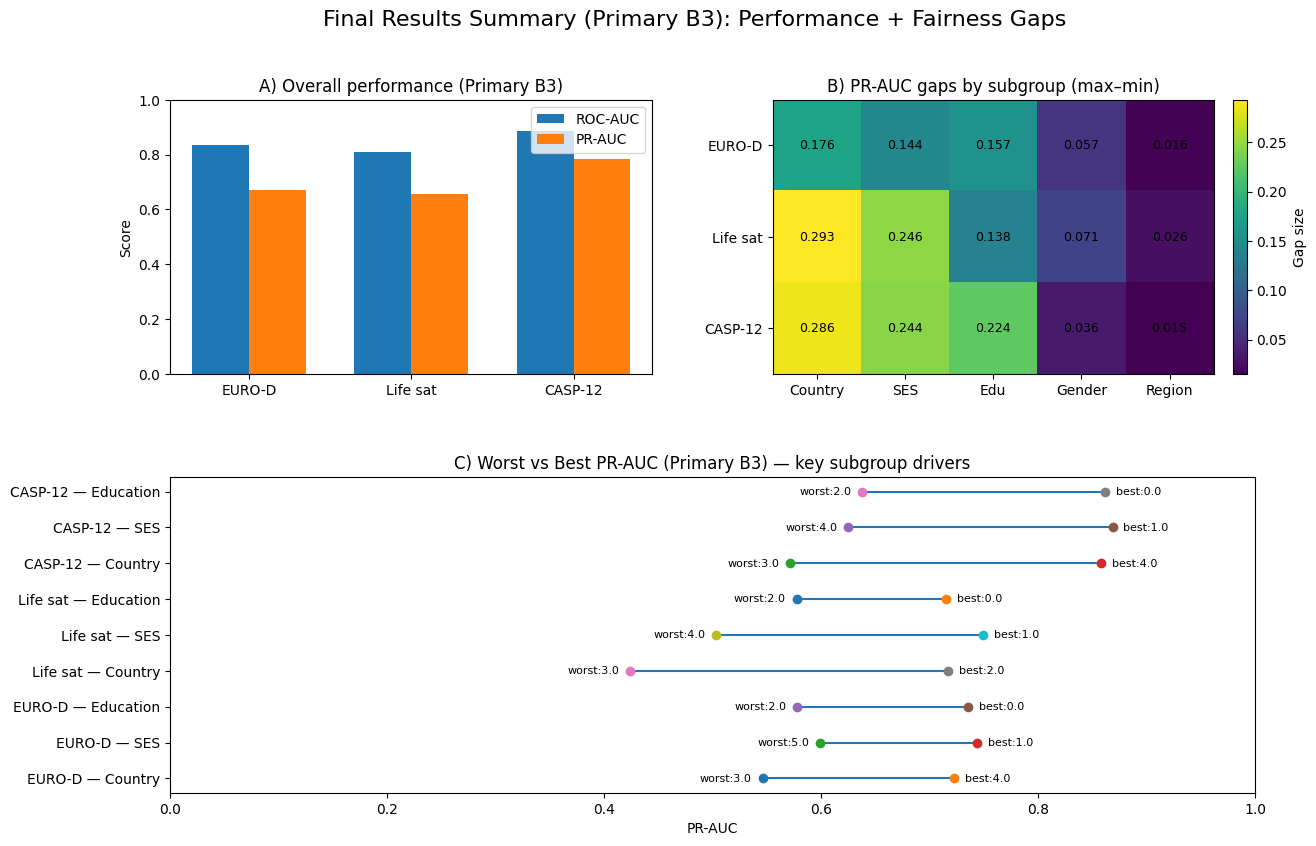

Saved: teacher_final_results_dashboard.png


In [ ]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- helper: find files anywhere in Colab ----
def find_file(filename, roots=("/content", "/content/drive")):
    hits = []
    for r in roots:
        if os.path.exists(r):
            hits += glob(os.path.join(r, "**", filename), recursive=True)
    return hits

# ---- load your final result tables ----
sum_hits = find_file("PRIMARY_summary_overall_and_gaps.csv")
ext_hits = find_file("PRIMARY_subgroup_extremes.csv")

if not sum_hits:
    raise FileNotFoundError("Upload/locate PRIMARY_summary_overall_and_gaps.csv in Colab (/content or Drive).")
if not ext_hits:
    raise FileNotFoundError("Upload/locate PRIMARY_subgroup_extremes.csv in Colab (/content or Drive).")

summary = pd.read_csv(sum_hits[0])
extremes = pd.read_csv(ext_hits[0])

# ---- normalize / order outcomes (nice labels) ----
order = ["eurod", "life_satisfaction", "casp12"]
summary["outcome"] = summary["outcome"].astype(str)
summary = summary.set_index("outcome").reindex(order).reset_index()

outcome_label = {
    "eurod": "EURO-D",
    "life_satisfaction": "Life sat",
    "casp12": "CASP-12",
}

# ---- dashboard layout ----
fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.15], width_ratios=[1, 1], hspace=0.35, wspace=0.25)

# =================================================
# Panel A (top-left): Overall ROC-AUC & PR-AUC bars
# =================================================
axA = fig.add_subplot(gs[0, 0])

x = np.arange(len(summary))
w = 0.35
axA.bar(x - w/2, summary["test_roc_auc"].values, width=w, label="ROC-AUC")
axA.bar(x + w/2, summary["test_pr_auc"].values,  width=w, label="PR-AUC")
axA.set_xticks(x)
axA.set_xticklabels([outcome_label.get(o, o) for o in summary["outcome"].tolist()])
axA.set_ylim(0, 1)
axA.set_title("A) Overall performance (Primary B3)")
axA.set_ylabel("Score")
axA.legend()

# ==========================================================
# Panel B (top-right): PR-AUC gap heatmap (max–min per group)
# ==========================================================
axB = fig.add_subplot(gs[0, 1])

subgroups = ["country_no", "ses_q", "edu_lv", "gender", "region"]
gap_cols = [f"{g}_pr_gap" for g in subgroups]

# build matrix: rows outcomes, cols subgroup vars
mat = []
for _, row in summary.iterrows():
    mat.append([row.get(c, np.nan) for c in gap_cols])
mat = np.array(mat, dtype=float)

im = axB.imshow(mat, aspect="auto")
axB.set_title("B) PR-AUC gaps by subgroup (max–min)")
axB.set_xticks(np.arange(len(subgroups)))
axB.set_xticklabels(["Country", "SES", "Edu", "Gender", "Region"], rotation=0)
axB.set_yticks(np.arange(len(order)))
axB.set_yticklabels([outcome_label.get(o, o) for o in order])

# annotate numbers
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        v = mat[i, j]
        if np.isfinite(v):
            axB.text(j, i, f"{v:.3f}", ha="center", va="center", fontsize=9)

cbar = fig.colorbar(im, ax=axB, fraction=0.046, pad=0.04)
cbar.set_label("Gap size")

# ==========================================================
# Panel C (bottom, full width): Dumbbells for key subgroups
# (worst vs best PR-AUC for Country / SES / Edu)
# ==========================================================
axC = fig.add_subplot(gs[1, :])

KEY = ["country_no", "ses_q", "edu_lv"]
key_labels = {"country_no": "Country", "ses_q": "SES", "edu_lv": "Education"}

# y positions: 3 outcomes × 3 key groups
y_labels = []
y_positions = []
segments = []  # (y, worst_pr, best_pr, label_worst, label_best)
y = 0

for o in order:
    for g in KEY:
        d = extremes[(extremes["outcome"] == o) & (extremes["group"] == g)]
        if d.empty:
            continue
        r = d.iloc[0]
        worst_pr = float(r["worst_pr"])
        best_pr  = float(r["best_pr"])
        wcat = str(r["worst_cat"])
        bcat = str(r["best_cat"])

        label = f"{outcome_label.get(o,o)} — {key_labels[g]}"
        y_labels.append(label)
        y_positions.append(y)
        segments.append((y, worst_pr, best_pr, wcat, bcat))
        y += 1

# draw dumbbells
for (yy, wpr, bpr, wcat, bcat) in segments:
    axC.hlines(yy, wpr, bpr)
    axC.plot(wpr, yy, marker="o")
    axC.plot(bpr, yy, marker="o")
    # small text labels for categories
    axC.text(wpr - 0.01, yy, f"worst:{wcat}", ha="right", va="center", fontsize=8)
    axC.text(bpr + 0.01, yy, f"best:{bcat}",  ha="left",  va="center", fontsize=8)

axC.set_yticks(y_positions)
axC.set_yticklabels(y_labels)
axC.set_xlim(0, 1)
axC.set_xlabel("PR-AUC")
axC.set_title("C) Worst vs Best PR-AUC (Primary B3) — key subgroup drivers")

# nice overall title
fig.suptitle("Final Results Summary (Primary B3): Performance + Fairness Gaps", fontsize=16, y=0.98)

outpath = "teacher_final_results_dashboard.png"
plt.savefig(outpath, dpi=250, bbox_inches="tight")
plt.show()

print("Saved:", outpath)

In [ ]:
import os, json, glob, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUTDIR = "outputs_qol_fairness"
SAVE_DIR = "teacher_feature_importance"
os.makedirs(SAVE_DIR, exist_ok=True)

PRIMARY = {
    "eurod": {"block":"B3"},
    "life_satisfaction": {"block":"B3"},
    "casp12": {"block":"B3"},
}

def find_model_file(run_dir):
    # common patterns
    patterns = [
        "model.pkl", "best_model.pkl",
        "*.pkl",
        "model.txt", "*.txt",
        "model.json", "*.json",
        "*.joblib"
    ]
    for pat in patterns:
        hits = glob.glob(os.path.join(run_dir, pat))
        if hits:
            # prefer pkl/joblib first
            hits = sorted(hits, key=lambda x: (0 if x.endswith((".pkl",".joblib")) else 1, len(x)))
            return hits[0]
    return None

def load_model(run_dir):
    mf = find_model_file(run_dir)
    if mf is None:
        return None, None
    # try joblib/pickle first
    if mf.endswith((".pkl",".joblib")):
        try:
            return joblib.load(mf), mf
        except Exception:
            return None, mf
    # if text/json model, return path (we'll handle by library if possible)
    return mf, mf

def load_pred_and_features(run_dir):
    # pred_test.csv contains y_true, p_hat, and subgroup cols.
    # But for feature importance we need X_test feature matrix.
    # If your pipeline saved X_test.csv, use it. Otherwise we fall back to reloading from final_cleaned + test_idx.
    pred_path = os.path.join(run_dir, "pred_test.csv")
    if not os.path.exists(pred_path):
        raise FileNotFoundError(pred_path)
    pred = pd.read_csv(pred_path)
    return pred

print("Ready. Next cell will try to locate models + feature matrices.")


Ready. Next cell will try to locate models + feature matrices.


In [ ]:
from sklearn.inspection import permutation_importance

def try_load_Xy(run_dir):
    # look for saved feature matrix files
    x_candidates = glob.glob(os.path.join(run_dir, "X_test.*")) + glob.glob(os.path.join(run_dir, "*X_test*.*"))
    y_candidates = glob.glob(os.path.join(run_dir, "y_test.*")) + glob.glob(os.path.join(run_dir, "*y_test*.*"))

    X = y = None

    if x_candidates:
        xp = x_candidates[0]
        if xp.endswith(".csv"):
            X = pd.read_csv(xp)
        elif xp.endswith(".parquet"):
            X = pd.read_parquet(xp)
        else:
            # try csv as fallback
            try:
                X = pd.read_csv(xp)
            except:
                pass

    if y_candidates:
        yp = y_candidates[0]
        if yp.endswith(".csv"):
            y = pd.read_csv(yp).squeeze()
        elif yp.endswith(".parquet"):
            y = pd.read_parquet(yp).squeeze()

    return X, y, x_candidates[:3], y_candidates[:3]

def plot_barh(names, values, title, outpath, topk=20):
    idx = np.argsort(values)[::-1][:topk]
    names = np.array(names)[idx]
    values = np.array(values)[idx]
    fig = plt.figure(figsize=(8, max(3, 0.35*len(names))))
    ax = plt.gca()
    ax.barh(names[::-1], values[::-1])
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=220, bbox_inches="tight")
    plt.close(fig)

for outcome, cfg in PRIMARY.items():
    run_dir = os.path.join(OUTDIR, outcome, cfg["block"])
    info_path = os.path.join(run_dir, "best_model.json")
    if not os.path.exists(info_path):
        print("[SKIP] missing", info_path)
        continue

    info = json.load(open(info_path, "r"))
    model_type = str(info.get("best_model", "")).lower()

    model, model_path = load_model(run_dir)
    X_test, y_test, x_hits, y_hits = try_load_Xy(run_dir)

    print(f"\n== {outcome} ({cfg['block']}) ==")
    print("best_model:", model_type)
    print("model file:", model_path)
    print("X_test hits:", x_hits)
    print("y_test hits:", y_hits)

    if model is None or X_test is None or y_test is None:
        print("-> Missing trained model object OR X_test/y_test. See fallback below.")
        continue

    # ----- Built-in importance -----
    # LightGBM sklearn API
    if "lgbm" in model_type or "lightgbm" in model_type:
        try:
            import lightgbm as lgb
            booster = model.booster_
            # gain importance
            imp_gain = booster.feature_importance(importance_type="gain")
            imp_split = booster.feature_importance(importance_type="split")
            feat_names = booster.feature_name()

            plot_barh(feat_names, imp_gain,
                      f"{outcome} — LightGBM importance (gain)",
                      os.path.join(SAVE_DIR, f"{outcome}_lgbm_importance_gain.png"), topk=20)
            plot_barh(feat_names, imp_split,
                      f"{outcome} — LightGBM importance (split)",
                      os.path.join(SAVE_DIR, f"{outcome}_lgbm_importance_split.png"), topk=20)
            print("Saved LGBM built-in importance plots.")
        except Exception as e:
            print("LGBM importance failed:", e)

    # XGBoost sklearn API
    if "xgb" in model_type or "xgboost" in model_type:
        try:
            import xgboost as xgb
            booster = model.get_booster()
            score = booster.get_score(importance_type="gain")  # dict: feature->gain
            # align to X_test columns
            feat_names = list(X_test.columns)
            values = [score.get(f, 0.0) for f in feat_names]
            plot_barh(feat_names, values,
                      f"{outcome} — XGBoost importance (gain)",
                      os.path.join(SAVE_DIR, f"{outcome}_xgb_importance_gain.png"), topk=20)
            print("Saved XGB built-in importance plot.")
        except Exception as e:
            print("XGB importance failed:", e)

    # ----- Permutation importance (more interpretable) -----
    try:
        perm = permutation_importance(
            model, X_test, y_test,
            n_repeats=5, random_state=42, n_jobs=-1,
            scoring="average_precision"  # matches your PR-AUC focus
        )
        plot_barh(X_test.columns, perm.importances_mean,
                  f"{outcome} — Permutation importance (ΔPR-AUC)",
                  os.path.join(SAVE_DIR, f"{outcome}_perm_importance_pr.png"), topk=20)
        print("Saved permutation importance plot.")
    except Exception as e:
        print("Permutation importance failed:", e)

print("\nAll done. Check folder:", SAVE_DIR)



== eurod (B3) ==
best_model: xgb
model file: outputs_qol_fairness/eurod/B3/best_model.json
X_test hits: []
y_test hits: []
-> Missing trained model object OR X_test/y_test. See fallback below.

== life_satisfaction (B3) ==
best_model: xgb
model file: outputs_qol_fairness/life_satisfaction/B3/best_model.json
X_test hits: []
y_test hits: []
-> Missing trained model object OR X_test/y_test. See fallback below.

== casp12 (B3) ==
best_model: lgbm
model file: outputs_qol_fairness/casp12/B3/best_model.json
X_test hits: []
y_test hits: []
-> Missing trained model object OR X_test/y_test. See fallback below.

All done. Check folder: teacher_feature_importance


In [ ]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

OUTDIR = "outputs_qol_fairness"
SUBGROUP_VARS = ["country_no","ses_q","edu_lv","gender","region"]

PRIMARY = {
    "eurod": {"block":"B3"},
    "life_satisfaction": {"block":"B3"},
    "casp12": {"block":"B3"},
}

def load_pred(outcome, block="B3", split="test"):
    path = os.path.join(OUTDIR, outcome, block, f"pred_{split}.csv")
    if not os.path.exists(path):
        return None, path
    return pd.read_csv(path), path

def safe_calibration(y, p, n_bins=10):
    # returns mean_pred, frac_pos
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=n_bins, strategy="quantile")
    return mean_pred, frac_pos

def valid_cats(pred_df, group_col, min_n=200, min_y=30):
    g = pred_df.groupby(group_col)["y_true"].agg(n="count", y1="sum")
    g["y0"] = g["n"] - g["y1"]
    ok = g[(g["n"]>=min_n) & (g["y1"]>=min_y) & (g["y0"]>=min_y)].index.tolist()
    return ok, g.reset_index()

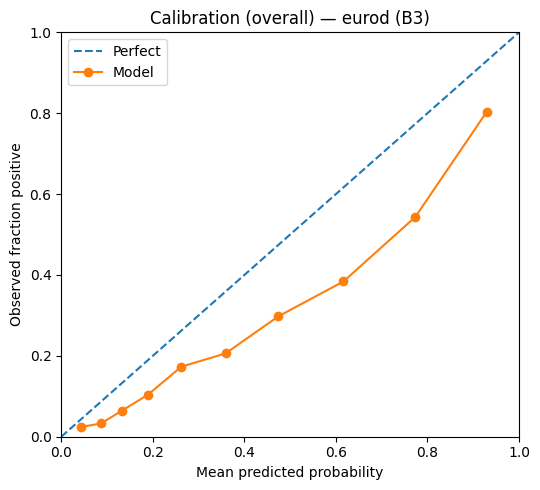

Saved: teacher_calibration/calibration_overall_eurod_B3.png


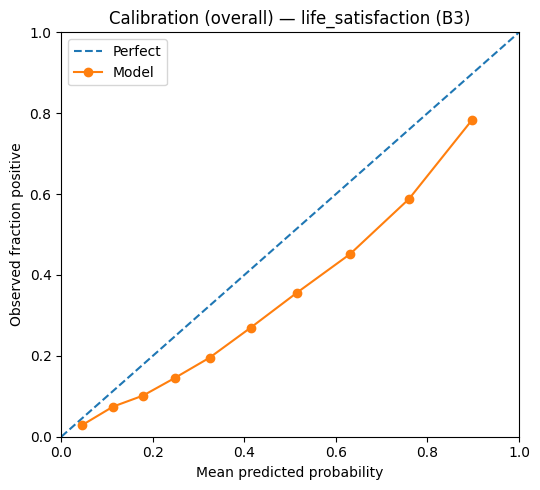

Saved: teacher_calibration/calibration_overall_life_satisfaction_B3.png


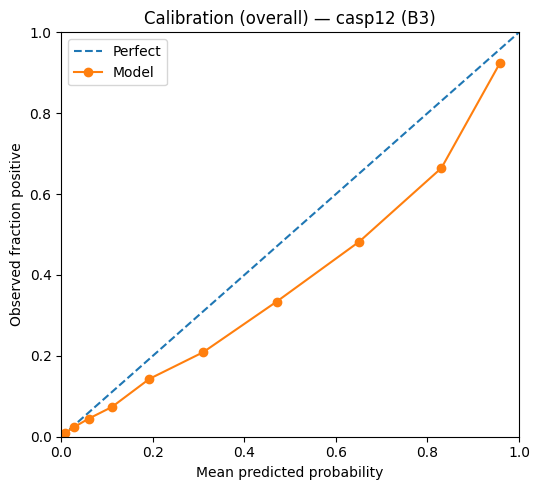

Saved: teacher_calibration/calibration_overall_casp12_B3.png


In [ ]:
SAVE_DIR = "teacher_calibration"
os.makedirs(SAVE_DIR, exist_ok=True)

for outcome, cfg in PRIMARY.items():
    pred, pth = load_pred(outcome, cfg["block"], split="test")
    if pred is None:
        print("[SKIP missing]", pth)
        continue

    y = pred["y_true"].values
    p = pred["p_hat"].values

    mean_pred, frac_pos = safe_calibration(y, p, n_bins=10)

    plt.figure(figsize=(5.5,5))
    plt.plot([0,1],[0,1], linestyle="--", label="Perfect")
    plt.plot(mean_pred, frac_pos, marker="o", label="Model")
    plt.title(f"Calibration (overall) — {outcome} (B3)")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Observed fraction positive")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.legend()
    plt.tight_layout()

    outpng = os.path.join(SAVE_DIR, f"calibration_overall_{outcome}_B3.png")
    plt.savefig(outpng, dpi=220, bbox_inches="tight")
    plt.show()
    plt.close()
    print("Saved:", outpng)

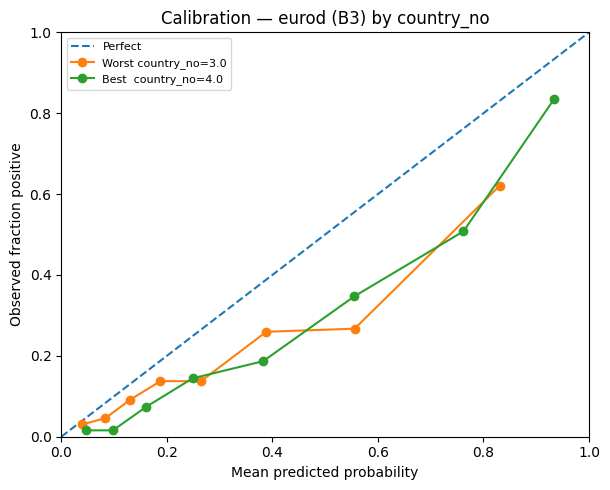

Saved: teacher_calibration/calibration_eurod_B3_country_no_worst_best.png


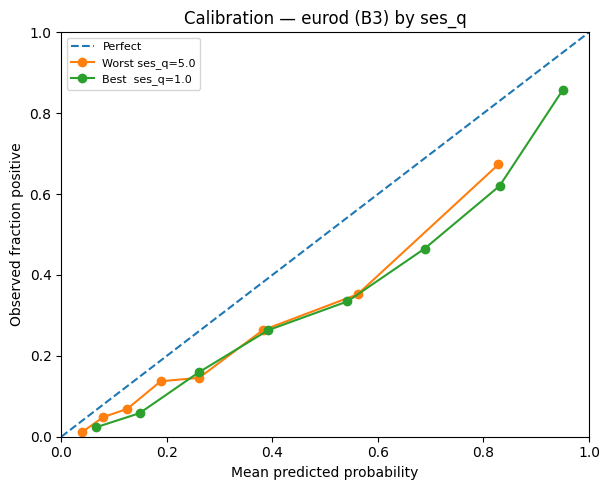

Saved: teacher_calibration/calibration_eurod_B3_ses_q_worst_best.png


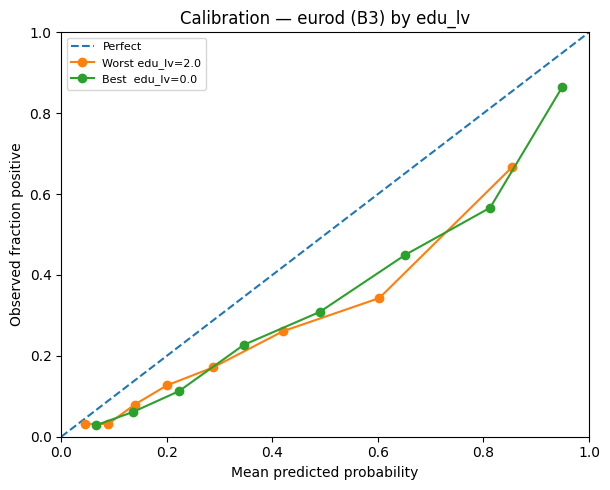

Saved: teacher_calibration/calibration_eurod_B3_edu_lv_worst_best.png


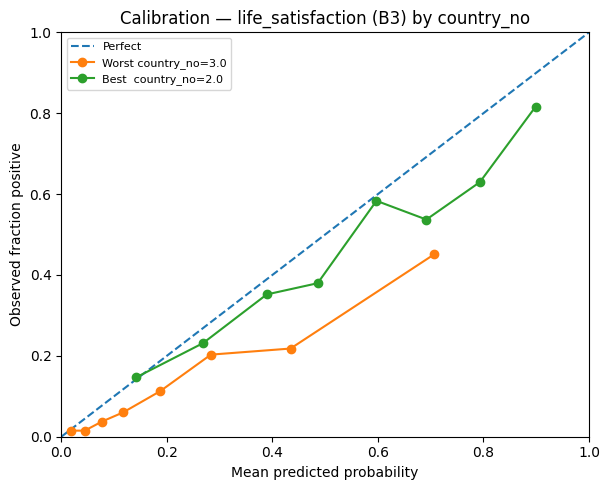

Saved: teacher_calibration/calibration_life_satisfaction_B3_country_no_worst_best.png


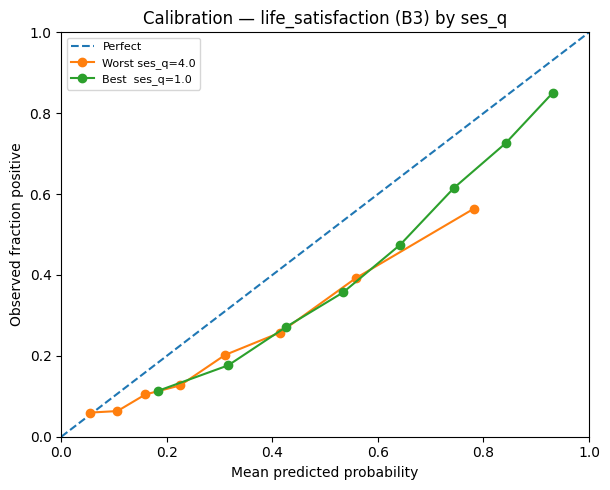

Saved: teacher_calibration/calibration_life_satisfaction_B3_ses_q_worst_best.png


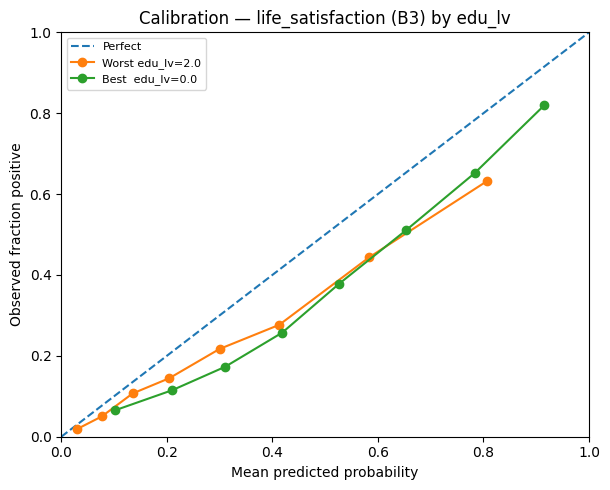

Saved: teacher_calibration/calibration_life_satisfaction_B3_edu_lv_worst_best.png


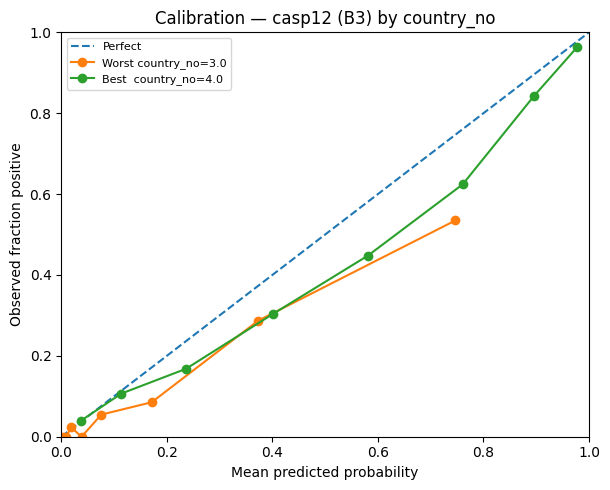

Saved: teacher_calibration/calibration_casp12_B3_country_no_worst_best.png


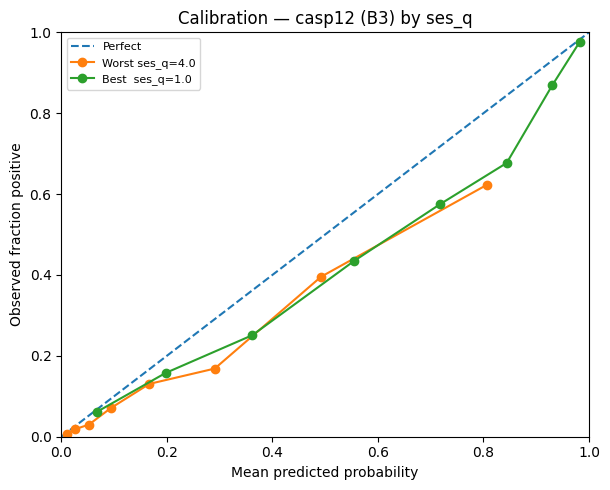

Saved: teacher_calibration/calibration_casp12_B3_ses_q_worst_best.png


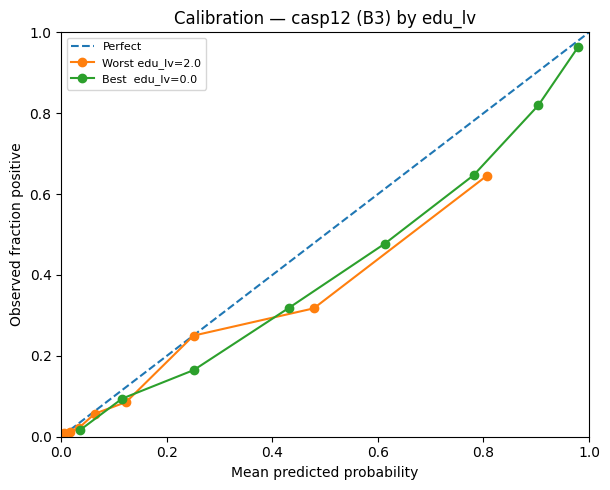

Saved: teacher_calibration/calibration_casp12_B3_edu_lv_worst_best.png


In [ ]:
# Find extremes csv anywhere
def find_file(filename, roots=("/content","/content/drive")):
    hits=[]
    for r in roots:
        if os.path.exists(r):
            hits += glob.glob(os.path.join(r,"**",filename), recursive=True)
    return hits

ext_hits = find_file("PRIMARY_subgroup_extremes.csv")
if not ext_hits:
    raise FileNotFoundError("Upload PRIMARY_subgroup_extremes.csv into Colab (/content).")
extremes = pd.read_csv(ext_hits[0])

SAVE_DIR = "teacher_calibration"
os.makedirs(SAVE_DIR, exist_ok=True)

KEY_GROUPS = ["country_no","ses_q","edu_lv"]  # your main story

for outcome, cfg in PRIMARY.items():
    pred, _ = load_pred(outcome, cfg["block"], split="test")
    if pred is None:
        continue

    for gcol in KEY_GROUPS:
        row = extremes[(extremes["outcome"]==outcome) & (extremes["group"]==gcol)]
        if row.empty:
            continue
        row = row.iloc[0]
        worst_cat = row["worst_cat"]
        best_cat  = row["best_cat"]

        sub_w = pred[pred[gcol]==worst_cat]
        sub_b = pred[pred[gcol]==best_cat]
        if sub_w.empty or sub_b.empty:
            continue

        plt.figure(figsize=(6.2,5))
        plt.plot([0,1],[0,1], linestyle="--", label="Perfect")

        for sub, lab in [(sub_w, f"Worst {gcol}={worst_cat}"),
                         (sub_b, f"Best  {gcol}={best_cat}")]:
            mp, fp = safe_calibration(sub["y_true"].values, sub["p_hat"].values, n_bins=8)
            plt.plot(mp, fp, marker="o", label=lab)

        plt.title(f"Calibration — {outcome} (B3) by {gcol}")
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Observed fraction positive")
        plt.xlim(0,1); plt.ylim(0,1)
        plt.legend(fontsize=8)
        plt.tight_layout()

        outpng = os.path.join(SAVE_DIR, f"calibration_{outcome}_B3_{gcol}_worst_best.png")
        plt.savefig(outpng, dpi=220, bbox_inches="tight")
        plt.show()
        plt.close()
        print("Saved:", outpng)

In [ ]:
# ============================================
# Download calibration curves (zip + download)
# - Collects all PNGs in teacher_calibration/
# - Zips them into teacher_calibration_curves.zip
# - Downloads the zip in Colab
# ============================================
import os, shutil, glob
from google.colab import files

CAL_DIR = "teacher_calibration"

if not os.path.exists(CAL_DIR):
    raise FileNotFoundError(
        f"Folder '{CAL_DIR}' not found. Run the calibration plotting cells first."
    )

pngs = sorted(glob.glob(os.path.join(CAL_DIR, "*.png")))
print(f"Found {len(pngs)} calibration curve PNGs in {CAL_DIR}")
for p in pngs[:10]:
    print(" -", p)
if len(pngs) > 10:
    print(" ...")

if len(pngs) == 0:
    raise FileNotFoundError(f"No PNGs found in '{CAL_DIR}'. Did you save the plots?")

zip_path = shutil.make_archive("teacher_calibration_curves", "zip", CAL_DIR)
print("Created zip:", zip_path)

files.download(zip_path)

Found 12 calibration curve PNGs in teacher_calibration
 - teacher_calibration/calibration_casp12_B3_country_no_worst_best.png
 - teacher_calibration/calibration_casp12_B3_edu_lv_worst_best.png
 - teacher_calibration/calibration_casp12_B3_ses_q_worst_best.png
 - teacher_calibration/calibration_eurod_B3_country_no_worst_best.png
 - teacher_calibration/calibration_eurod_B3_edu_lv_worst_best.png
 - teacher_calibration/calibration_eurod_B3_ses_q_worst_best.png
 - teacher_calibration/calibration_life_satisfaction_B3_country_no_worst_best.png
 - teacher_calibration/calibration_life_satisfaction_B3_edu_lv_worst_best.png
 - teacher_calibration/calibration_life_satisfaction_B3_ses_q_worst_best.png
 - teacher_calibration/calibration_overall_casp12_B3.png
 ...
Created zip: /content/teacher_calibration_curves.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shap

def _get_feature_names(preprocess, X_df):
    """
    Robustly get feature names after ColumnTransformer.
    Works for sklearn >= 1.0 in most cases.
    """
    try:
        return preprocess.get_feature_names_out()
    except Exception:
        # fallback: generic names
        n = preprocess.transform(X_df.iloc[:1]).shape[1]
        return np.array([f"f{i}" for i in range(n)])

def shap_bar_and_summary(
    pipe,
    X,                       # pandas DataFrame (same columns as training)
    outcome_name="casp12_B3",
    outdir="outputs/shap",
    sample_size=2000,        # keep it fast
    max_display=10,
    dpi=300
):
    os.makedirs(outdir, exist_ok=True)

    preprocess = pipe.named_steps["preprocess"]
    model = pipe.named_steps["model"]

    # ---- sample for speed (SHAP can be heavy) ----
    if len(X) > sample_size:
        X_use = X.sample(sample_size, random_state=42)
    else:
        X_use = X.copy()

    # ---- transform features (what the model actually sees) ----
    X_enc = preprocess.transform(X_use)
    feat_names = _get_feature_names(preprocess, X_use)

    # Some SHAP + matplotlib combos behave better with dense arrays
    # If it’s sparse, densify only if it’s not too big.
    try:
        import scipy.sparse as sp
        if sp.issparse(X_enc):
            # densify cautiously
            X_enc_dense = X_enc.toarray()
        else:
            X_enc_dense = X_enc
    except Exception:
        X_enc_dense = X_enc

    # ---- SHAP for tree models (LightGBM) ----
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_enc_dense)

    # For binary classifiers, shap_values can be:
    # - list of 2 arrays (per class) OR
    # - single array depending on shap version
    if isinstance(shap_values, list):
        # class 1 contributions (bad outcome = 1)
        sv = shap_values[1]
    else:
        sv = shap_values

    # ---- global importance (mean |SHAP|) ----
    mean_abs = np.mean(np.abs(sv), axis=0)
    order = np.argsort(mean_abs)[::-1]
    top = order[:max_display]

    # ---- Plot: left bar + right summary (like paper) ----
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.6), gridspec_kw={"width_ratios":[1.05, 1.2]})

    # Left: bar plot
    ax = axes[0]
    ax.barh(range(len(top)), mean_abs[top][::-1])
    ax.set_yticks(range(len(top)))
    ax.set_yticklabels(np.array(feat_names)[top][::-1])
    ax.set_xlabel("mean(|SHAP value|)")
    ax.set_title(f"Bar Plot - LightGBM\n{outcome_name}")
    ax.grid(axis="x", alpha=0.2)

    # Right: SHAP summary plot on the same figure
    plt.sca(axes[1])
    shap.summary_plot(
        sv,
        X_enc_dense,
        feature_names=feat_names,
        max_display=max_display,
        show=False,           # IMPORTANT: draw onto current axes
        plot_type="violin"    # closest to your example
    )
    axes[1].set_title(f"Summary Plot - LightGBM\n{outcome_name}")

    plt.tight_layout()

    png_path = os.path.join(outdir, f"shap_{outcome_name}_bar_summary.png")
    pdf_path = os.path.join(outdir, f"shap_{outcome_name}_bar_summary.pdf")
    fig.savefig(png_path, dpi=dpi, bbox_inches="tight")
    fig.savefig(pdf_path, bbox_inches="tight")
    plt.close(fig)

    print("Saved:", png_path)
    print("Saved:", pdf_path)

# ---- Example usage (run at the very end) ----
# shap_bar_and_summary(best_pipe, X_test, outcome_name="casp12_B3")
# shap_bar_and_summary(best_pipe, X_test, outcome_name="eurod_B3")
# shap_bar_and_summary(best_pipe, X_test, outcome_name="life_satisfaction_B3")
